### Import Modules

In [1]:
import procsimulator
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from procsimulator.CommunityGenerator import CommunityGenerator
from procsimulator.ConsumptionGenerator import ConsumptionGenerator
from procsimulator.DataFromSmile import DataFromSmile
from procsimulator.DataFromTomorrow import DataFromTomorrow
from procsimulator.RenewableEnergyGenerator import RenewableEnergyGenerator
from procsimulator.CommunityGenerator import CommunityGenerator
from procsimulator.Evaluation import Evaluation
from procsimulator.CommunityManagerStrategy import CommunityManagerStrategy

### Get current path

In [3]:
current_path = os.getcwd()
print(current_path)

C:\Users\Nuno.Velosa.CORP\OneDrive - Unipartner IT Services, S.A\Desktop\Energy_Community_Simulation


### Generation of the consumption profiles

In [4]:
path_steps_seconds = os.path.join(current_path)
path_steps_minutes = "output/minute"
path_steps_after_first = "output/afterfirstoptimization"
path_steps_after_second = "output/aftersecondoptimization"
num_days = "1"
generate_community = False

In [5]:
cg = ConsumptionGenerator("data.json", path_steps_seconds, path_steps_minutes)
community = cg.get_community()
print(path_steps_seconds)
if (generate_community):
    cg.execute(num_days, "houses")

C:\Users\Nuno.Velosa.CORP\OneDrive - Unipartner IT Services, S.A\Desktop\Energy_Community_Simulation


In [6]:
import datetime

# Just in case we need to change the dates of the consumption profiles in order to get PV and Wind forecast for different days
# This happens because the production is obtained for the same days as the consumption in order to make it more realistic

path = "output"

def update_dataframe(path):    
    if ("events" not in path):
        df = pd.read_csv(path, sep=';')

        try:
            df["Date"] = df["Date"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S") - pd.Timedelta(days=102))
        except:
            df.columns=['Date','Power']
            df["Date"] = df["Date"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S") - pd.Timedelta(weeks=102))
        #print(df['Date'])
            
        x = path.rsplit('/', 1)
        #print(x)

        output_directory = os.path.join('', x[0])
        outname = os.path.join(output_directory, x[1])
        df.to_csv(outname, sep=";", index=False)


for folder in os.listdir(path):
    print("")
    file = path + "/" + folder
    for f in os.listdir(file):
        df_path = file + "/" + f
        print(df_path)
        
        #if (os.path.isdir(df_path)):
            #for fm in os.listdir(df_path):
                #update_dataframe(df_path + "/" + fm)
        #else:
            #update_dataframe(df_path)




output/afterfirstoptimization/community.csv
output/afterfirstoptimization/community_baseload.csv
output/afterfirstoptimization/community_not_baseload.csv
output/afterfirstoptimization/energy.csv
output/afterfirstoptimization/house0
output/afterfirstoptimization/house1
output/afterfirstoptimization/house2
output/afterfirstoptimization/house3
output/afterfirstoptimization/house4
output/afterfirstoptimization/netload.csv

output/house0/AMPLIFIER.csv
output/house0/Ann.csv
output/house0/baseload.csv
output/house0/BREADCUTTER.csv
output/house0/CDPLAYER.csv
output/house0/COFFEEMAKER.csv
output/house0/COOKINGSTOVE.csv
output/house0/cooking_a_dinner.csv
output/house0/DISHWASHER.csv
output/house0/DRYER.csv
output/house0/events.csv
output/house0/FREEZER.csv
output/house0/fridge_operation.csv
output/house0/IRON.csv
output/house0/KETTLE.csv
output/house0/listen_to_a_74_minute_audio_CD.csv
output/house0/MICROWAVE.csv
output/house0/microwaving_food.csv
output/house0/PC.csv
output/house0/preparing_br

### Wind Weather Data

In [7]:
import requests

def get_weather_data_from_file(filename="weather.csv"):

  file = os.path.join("", filename)

  if not os.path.isfile(file):
    #logging.debug("Download weather data for example.")
    req = requests.get("https://osf.io/59bqn/download")
    with open(file, "wb") as fout:
      fout.write(req.content)


  weather_df = pd.read_csv(
    file,
    index_col=0,
    header=[0, 1],
    date_parser=lambda idx: pd.to_datetime(idx, utc=True))

  # change time zone
  weather_df.index = weather_df.index.tz_convert('Europe/Berlin')

  return weather_df



def get_weather_data(url, save_to_file=False, filename="weather_data.csv"):
  """
  Gets weather data from Tomorrow.io API

  Returns:
    dataframe with wind data
  """

  # Using Tomorrow.io API to get wind data
  if (save_to_file):

    wind_data_from_file = get_weather_data_from_file()

    wind_data = requests.get(url)
    intervals = wind_data.json()["data"]["timelines"][0]["intervals"][1:]


    for i in intervals:
      i["wind_speed"] = i["values"]["windSpeed"]
      i["temperature"] = i["values"]["temperature"]
      i["pressure"] = i["values"]["pressureSurfaceLevel"]
      del i['values']


    wind_data_df = pd.DataFrame.from_dict(intervals[:25])
    wind_data_df['startTime'] = pd.to_datetime(wind_data_df['startTime'])
    wind_data_df = wind_data_df.set_index('startTime')


    # print(weather[['wind_speed', 'temperature', 'pressure']][:25]["wind_speed"][10])
    n_row = 0
    wind_data_from_file = wind_data_from_file.reset_index()
    wind_data_df = wind_data_df.reset_index()


    #print(wind_data_df)
    #print(wind_data_from_file[['index', 'wind_speed', 'temperature', 'pressure']][:25]["wind_speed"]["10"])


    for index, i in wind_data_from_file[['index', 'wind_speed', 'temperature', 'pressure']][:24].iterrows():
      #print(wind_data_from_file.loc[index, "wind_speed"])
      #print(wind_data_df.iloc[n_row]["wind_speed"])
      wind_data_from_file.loc[index, "wind_speed"] = wind_data_df.iloc[n_row]["wind_speed"]
      wind_data_from_file.loc[index, "temperature"] = wind_data_df.iloc[n_row]["temperature"]
      wind_data_from_file.loc[index, "pressure"] = wind_data_df.iloc[n_row]["pressure"]
      wind_data_from_file.loc[index, "index"] = wind_data_df.iloc[n_row]["startTime"]
      # print(weather.loc[index, "startTime"])
      n_row += 1

    wind_data_from_file.set_index('index', inplace=True)
    wind_data_df = wind_data_from_file

    wind_data_df[:25*int(num_days)].to_csv(filename)


  file = os.path.join("", filename)

  wind_data_df = pd.read_csv(
    file,
    index_col=0,
    header=[0, 1],
    date_parser=lambda idx: pd.to_datetime(idx, utc=True))

  # change time zone
  wind_data_df.index = wind_data_df.index.tz_convert('Europe/Berlin')

  return wind_data_df[:25*int(num_days)]


if (generate_community):
  wind_weather_df = get_weather_data("https://api.tomorrow.io/v4/timelines?startTime=now&endTime=nowPlus1d&location=32.756,-17.179&fields=pressureSurfaceLevel,pressureSeaLevel,precipitationIntensity,precipitationType,windSpeed,windGust,windDirection,temperature,temperatureApparent,cloudCover,cloudBase,cloudCeiling,weatherCode&timesteps=1h&units=metric&apikey=Yckmp3vREbJqyprWGGiTOC1pVaAYO0ZT", save_to_file=False)
  print(wind_weather_df)

### PV Weather Data

In [8]:
pv_dat = DataFromSmile("https://ems.prsma.com/solcast/public/Fazendinha_solcast-radiation-historical_30min.csv")

if (generate_community):
  #wind_dat = DataFromTomorrow("https://api.tomorrow.io/v4/timelines?startTime=now&endTime=nowPlus" + str(num_days) + "d&location=32.756,-17.179&fields=pressureSurfaceLevel,pressureSeaLevel,precipitationIntensity,precipitationType,windSpeed,windGust,windDirection,temperature,temperatureApparent,cloudCover,cloudBase,cloudCeiling,weatherCode&timesteps=1h&units=metric&apikey=Yckmp3vREbJqyprWGGiTOC1pVaAYO0ZT")
  print(pv_dat.get_weather_data())

### PV and Wind Generation Profiles

In [9]:
# Create empty dataframe
pv_df = pd.DataFrame(columns=['date', 'pv_power'])
wind_dat = pd.DataFrame()
reg = RenewableEnergyGenerator(cg, pv_dat, wind_dat, cg.path_steps_minutes)

if (generate_community):

  #reg.execute(num_days)

  print("Renewable Energy Generator")
  data = reg.pv_dat.get_weather_data()
  resampled_data = reg.pv_dat.resample_data(data, "1min")
  power = reg.get_pv_power(resampled_data, 2, 1000, 32.756, -17.179)

  community = pd.read_csv(reg.path_steps_minutes + '/community.csv', sep=';')
  community.columns = ['Date', 'Power']
  first_date = reg.get_first_and_last_date_of_community()[0]
  last_date = reg.get_first_and_last_date_of_community()[1]
  filtered_data = reg.pv_dat.filter_data(power, first_date, last_date)

  # Update energy csv file
  output_directory = os.path.join('', reg.path_steps_minutes)
  outname = os.path.join(output_directory, 'energy.csv')
  filtered_data.to_csv(outname, columns=['Date', 'Power'], sep=";", index=False)

  # Set Index of Community Needs
  community = community.set_index('Date')
  community.index = pd.to_datetime(community.index)

  # Set Index of PV Power Forecast
  filtered_data = filtered_data.set_index('Date')
  filtered_data['Power'] = filtered_data['Power'].fillna(0)
  filtered_data.index = pd.to_datetime(filtered_data.index)

  energy_contracted_power = reg.cg.calculate_contracted_power(reg.cg.get_community())*0.5
  print("energy contracted: " + str(energy_contracted_power))

  filtered_data = reg.normalize_power_dataframe(filtered_data, 220, energy_contracted_power) # Normalize dataframe and multiply by 220
  filtered_data.loc[filtered_data['Power'] < 0, 'Power'] = 0 # Remove negative power (convert it to zero)

  # Merges the community demand with the PV production
  production = pd.merge(community, filtered_data, on='Date')
  production = production.reset_index()


  print(wind_weather_df)
  # Calculates wind power based on weather data
  wind_power_df = reg.get_wind_power(wind_weather_df, energy_contracted_power*0.2, num_days)
  print(wind_power_df)

  # Upsample to steps of 1 minute
  wind_power_df.index = pd.to_datetime(wind_power_df.index, utc=True) # In order to resample, the index have to be converted in datetime index
  wind_power_df = wind_power_df.resample('1T').interpolate(method='polynomial',order=3)[:25*60*int(num_days)][:-1]

  print(wind_power_df)

  wind_power_df = wind_power_df.reset_index() # Remove index in order to change the column name
  wind_power_df = wind_power_df.rename({'index': 'Date'}, axis=1) # Change column names

  wind_power_df["Date"] = production["Date"] # Update the wind production dates to the same as the netload dataframe

  wind_power_df = wind_power_df.set_index('Date')
  wind_power_df.index = pd.to_datetime(wind_power_df.index)



  # Reindex columns and renames
  production = production.reindex(columns=['Date', 'Power_y', 'Power_x'])
  production = production.rename({'Power_y': 'PV_Production', 'Power_x': 'Demand'}, axis=1) # Change column names


  # Sets index in order to allow to merge with winder_power_df dataframe
  production = production.set_index('Date')
  production.index = pd.to_datetime(production.index)


  # Merge wind production with the production (demand + pv production)
  production = pd.merge(production, wind_power_df, on='Date')
  production = production.rename({'feedin_power_plant': 'Wind_Production'}, axis=1) # Change column names
  production = production.reset_index()


  # Calculates total production (PV and Wind)
  production["Wind_Production"] = 0
  production["Production"] = production["PV_Production"] + production["Wind_Production"]

  # Create netload csv file to store the production
  output_directory = os.path.join('', reg.path_steps_minutes)
  outname = os.path.join(output_directory, 'netload.csv')
  production.to_csv(outname, columns=['Date', 'Demand', 'PV_Production', 'Wind_Production', 'Production'], sep=";", index=False)

### Calculation of netload and Generation of the EC dataset

In [10]:
if (generate_community):
  cmg = CommunityGenerator(cg.path_steps_minutes)
  cmg.execute()

### Calculate metrics in the EC dataset

In [11]:
df = pd.read_csv(path_steps_minutes + '/netload.csv', sep=';')
evaluation = Evaluation(df, 0)

print("Average Power Used from Grid: " + "{:.2f}".format(evaluation.get_average_power_used_from_grid()) + " kW")
print("Average Power Used from PV: " + "{:.2f}".format(evaluation.get_average_power_used_from_pv()) + " kW")
print("Average Power Not Used from PV: " + "{:.2f}".format(evaluation.get_average_power_not_used_from_pv()) + " kW")
print("Energy Used from Grid: " + "{:.2f}".format(evaluation.get_energy_used_from_grid()) + " kWh")
print("Energy Used from PV: " + "{:.2f}".format(evaluation.get_energy_used_from_pv()) + " kWh")
print("Energy Not Used from PV: " + "{:.2f}".format(evaluation.get_energy_not_used_from_pv()) + " kWh")
print("Peaks Number: " + str(evaluation.get_peaks_number()))
print("Self Sufficiency (SS): " + "{:.2f}".format(evaluation.get_self_sufficiency()*100) + "%")
print("Self Consumption (SC): " + "{:.2f}".format(evaluation.get_self_consumption()*100) + "%")

Average Power Used from Grid: 2.07 kW
Average Power Used from PV: 1.19 kW
Average Power Not Used from PV: 7.24 kW
Energy Used from Grid: 49.72 kWh
Energy Used from PV: 28.67 kWh
Energy Not Used from PV: 173.74 kWh
Peaks Number: 822
Self Sufficiency (SS): 36.57%
Self Consumption (SC): 14.16%


### Calculation of Community PPC

In [12]:
# Getting the community contracted power
community = cg.get_community()
print("Contracted Power: " + str(cg.calculate_contracted_power(community)))

Calculating the contracted power of the community
Contracted Power: 29900.0


### Individual Houses PV Profiles

In [13]:
# Based on the PV capacity provided in the assets of the JSON configuration file, it calculates the PV profiles for each house
pv_power_df = pd.read_csv(path_steps_minutes + '/energy.csv', sep=";")
pv_power_df.columns = ["Date", "Power"]

pv_power_df = pv_power_df.set_index('Date')
pv_power_df['Power'] = pv_power_df['Power'].fillna(0)
pv_power_df.index = pd.to_datetime(pv_power_df.index)


for index, house in enumerate(community):
  #total_house_power = [assets["capacity"] for house in community for assets in house["assets"] if assets["type"] == "pv"]
  total_house_pv_capacity = sum([assets["capacity"] for assets in house["assets"] if assets["type"] == "pv"])
  house_power = reg.normalize_power_dataframe(pv_power_df, 220, total_house_pv_capacity)
  print(path_steps_minutes + '/house' + str(index) + '/energy.csv')
  house_power.to_csv(path_steps_minutes + '/house' + str(index) + '/energy.csv', sep=";")
  #print(house_power)

  house_s_df = pd.DataFrame([[assets["initial_soc"],assets["min"],assets["max"]] for assets in house["assets"] if assets["type"] == "storage"])
  if len(house_s_df) > 0:
    house_s_df = house_s_df.reset_index()
    house_s_df.columns = ["Index","SOC", "Min", "Max"]
  else:
    # Create empty dataframe
    house_s_df = pd.DataFrame(columns=["SOC", "Min", "Max"])
  house_s_df.to_csv(path_steps_minutes + '/house' + str(index) + '/house_s.csv', sep=";", index=False, columns=["SOC", "Min", "Max"])


output/minute/house0/energy.csv
output/minute/house1/energy.csv
output/minute/house2/energy.csv
output/minute/house3/energy.csv
output/minute/house4/energy.csv


### Optimize the Community

In [14]:
import pyomo
import pyomo.opt
import pyomo.environ as pyo
import numpy as np

In [15]:
def _auxDictionary(a):
  temp_dictionary = {}
  if len(a.shape) == 3:
    for dim0 in np.arange(a.shape[0]):
      for dim1 in np.arange(a.shape[1]):
        for dim2 in np.arange(a.shape[2]):
          temp_dictionary[(dim0+1, dim1+1, dim2+1)] = a[dim0, dim1, dim2]
  elif len(a.shape) == 2:
    for dim0 in np.arange(a.shape[0]):
      for dim1 in np.arange(a.shape[1]):
        temp_dictionary[(dim0+1, dim1+1)] = a[dim0, dim1]
  else:
    for dim0 in np.arange(a.shape[0]):
      temp_dictionary[(dim0+1)] = a[dim0]
  return temp_dictionary

In [16]:
def ext_pyomo_vals(vals):
    # make a pd.Series from each
    s = pd.Series(vals.extract_values(),
                  index=vals.extract_values().keys())
    # if the series is multi-indexed we need to unstack it...
    if type(s.index[0]) == tuple:    # it is multi-indexed
        s = s.unstack(level=1)
    else:
        # force transition from Series -> df
        s = pd.DataFrame(s)
    return s

In [17]:
def convert_to_tuple_dict(arr, data):
  # Convert 3-dimentional array to dict
  new_dict = {}
  for i, house in enumerate(arr):
    for j in np.arange(data['max_tims']):
      if (j >= len(house)):
        for k in np.arange(data['max_len']):
          new_dict[(i+1, j+1, k+1)] = 0
      else:
        tim = house[j]
        for k in np.arange(data['max_len']):
          if (k < len(tim)):
            new_dict[(i+1, j+1, k+1)] = tim[k]
          else:
            new_dict[(i+1, j+1, k+1)] = 0
  return new_dict

In [72]:
import matplotlib.pyplot as plt
import numpy as np

class KnapsackBalancing:

  def __init__(self, dates, items, bin_capacities, numbers, bins_maximum, items_maximum, baseload, fact, n_bins_per_hour, flexibilities, export_prices, import_prices, num_evs, evs_max, evs_min, evs_trip, initial_soc, evs_availability, evs_travelling, efficiency, p_charger, degradation_cost, p_grid_max, num_ess, s_max, s_min, s_initial_soc, num_houses, houses_production, house_items, house_items_max, house_items_date, house_items_num, house_items_flex, house_s_soc, house_s_max, house_s_min):
    """
    This class receives as input some arrays with information about the timeslots and the bins, as well as some global data (baseload, fact and n_bins_per_hour)

    Args:
      dates: array containing the bin in which the user wants to place the timeslot
      items: array containing the timeslot energy for each item of each timeslot
      bin_capacities: array containing the bin capactity of each bin
      numbers: array containing the number of the timeslot of each item of each timeslot
      bins_maximum: array containing the maximum power of the production of each bin
      items_maximum: array containing the maximum power of each item of each timeslot
      baseload: value that represents the value of energy that can be acquired from the grid in the 2nd step
      fact: minutes of each bin (e.g. if bins of 30 minutes, fact = 30)
      n_bins_per_hour: number of bins per hour (parameter of the strategy) to know the quantity of bins in a day (e.g. if bins of 30 minutes, n_bins_per_hour = 2)
      flexibilities: array contanining the flexibility of each item of each timeslot
      energy_prices: array containing the energy prices of each bin
    """
    self.dates = dates
    self.items = items
    self.numbers = numbers
    self.baseload = baseload
    self.bin_capacities = bin_capacities
    self.bins_maximum = bins_maximum
    self.items_maximum = items_maximum
    self.fact = fact
    self.n_bins_per_hour = n_bins_per_hour
    self.num_bins = n_bins_per_hour * 24
    self.flexibilities = flexibilities
    self.export_prices = export_prices
    self.import_prices = import_prices
    self.num_evs = num_evs
    self.maximum_soc = evs_max
    self.minimum_soc = evs_min
    self.etrip = evs_trip
    self.initial_soc = initial_soc
    self.availability = evs_availability
    self.travelling = evs_travelling
    self.efficiency = efficiency
    self.p_charger = p_charger
    self.degradation_cost = degradation_cost
    self.p_grid_max = p_grid_max
    self.num_ess = num_ess
    self.s_maximum_soc = s_max
    self.s_minimum_soc = s_min
    self.s_initial_soc = s_initial_soc
    self.num_houses = num_houses
    self.houses_production = houses_production
    self.house_items = house_items
    self.house_items_max = house_items_max
    self.house_items_date = house_items_date
    self.house_items_num = house_items_num
    self.house_items_flex = house_items_flex
    self.house_s_soc = house_s_soc
    self.house_s_max = house_s_max
    self.house_s_min = house_s_min
    self.h_prod = houses_production
    self.dataframes = {}


  def create_data_model(self):
    """
    Creates the data model for the Multi Knapsack problem, according to the input received in the constructor

    Returns:
      data model (list with different arrays and values)
    """
    data = {}
    #data['tim_lens'] = [len(i) for i in self.items]
    #data['max_len'] = max(data['tim_lens'])

    data['tim_lens'] = []
    for i in self.house_items:
      tmp = []
      for j in i:
        tmp.append(len(j))
      data['tim_lens'].append(tmp)


    data['max_tims'] = max([max(i) for i in data['tim_lens']]) # Maximum number of timeslots
    data['max_len'] = max([len(i) for i in data['tim_lens']]) # Maximum number of items
    data['tim_lens'] = pd.DataFrame(data['tim_lens']).fillna(0)
    data['weights'] = pd.DataFrame(self.items).fillna(0)
    data['dates'] = pd.DataFrame(self.dates).fillna(0)
    data['numbers'] = pd.DataFrame(self.numbers).fillna(0)
    data['items'] = list(range(len(self.items)))
    data['num_items'] = len(self.items)
    num_bins = len(self.bin_capacities)
    data['bins'] = list(range(num_bins))
    data['bin_capacities'] = pd.DataFrame(self.bin_capacities)
    data['bins_maximum'] = pd.DataFrame(self.bins_maximum)
    data['items_maximum'] = pd.DataFrame(self.items_maximum).fillna(0)
    data['baseload'] = self.baseload
    data['fact'] = self.fact
    data['n_bins_per_hour'] = self.n_bins_per_hour
    data['num_bins'] = self.num_bins
    data['flexibilities'] = pd.DataFrame(self.flexibilities).fillna(0)
    data['export_prices'] = pd.DataFrame(self.export_prices)
    data['import_prices'] = pd.DataFrame(self.import_prices)
    data['num_evs'] = self.num_evs
    data['maximum_soc'] = self.maximum_soc
    data['minimum_soc'] = self.minimum_soc
    data['ev_trip'] = self.etrip
    data['initial_soc'] = self.initial_soc
    data['availability'] = self.availability
    data['travelling'] = self.travelling
    data['efficiency'] = self.efficiency
    data['p_charger'] = self.p_charger
    data['degradation_cost'] = self.degradation_cost
    data['p_grid_max'] = self.p_grid_max
    data['num_ess'] = self.num_ess
    data['s_maximum_soc'] = self.s_maximum_soc
    data['s_minimum_soc'] = self.s_minimum_soc
    data['s_initial_soc'] = self.s_initial_soc
    data['num_houses'] = self.num_houses
    data['tim_st'] = [len(i) for i in self.house_s_soc]
    data['max_st'] = max(data['tim_st'])
    data['houses_production'] = self.houses_production
    data['house_items'] = self.house_items
    data['house_items_max'] = self.house_items_max
    data['house_items_date'] = self.house_items_date
    data['house_items_num'] = self.house_items_num
    data['house_items_flex'] = self.house_items_flex
    data['house_s_soc'] = pd.DataFrame(self.house_s_soc).fillna(0) # Need to use dataframes instead of numpy arrays when the shape is not the same elements (for instance, we have a timeslot with 5 items and another one with 3 items, or a house with 2 timeslots and another one with 4)
    data['house_s_max'] = pd.DataFrame(self.house_s_max).fillna(0)
    data['house_s_min'] = pd.DataFrame(self.house_s_min).fillna(0)
    data['h_prod'] = self.h_prod
    return data


  def create_sets(self, model, data):

    model.b = pyo.Set(initialize = np.arange(1, data['num_bins'] + 1))
    model.t = pyo.Set(initialize = np.arange(1, data['max_tims'] + 1))
    model.i = pyo.Set(initialize = np.arange(1, data['max_len'] + 1))
    model.ev = pyo.Set(initialize = np.arange(1, data['num_evs'] + 1))
    model.s = pyo.Set(initialize = np.arange(1, data['num_ess'] + 1))
    model.h = pyo.Set(initialize = np.arange(1, data['num_houses'] + 1))
    model.hs = pyo.Set(initialize = np.arange(1, data['max_st'] + 1))


  def create_parameters(self, model, data):

    model.tim_lens = pyo.Param(model.h, model.t, initialize = _auxDictionary(np.array(data['tim_lens'])))
    model.weights = pyo.Param(model.h, model.t, model.i, initialize = convert_to_tuple_dict(data['house_items'], data))
    model.dates = pyo.Param(model.h, model.t, model.i, initialize = convert_to_tuple_dict(data['house_items_date'], data))
    model.numbers = pyo.Param(model.h, model.t, model.i, initialize = convert_to_tuple_dict(data['house_items_num'], data))
    model.bin_capacities = pyo.Param(model.b, initialize = _auxDictionary(np.array(data['bin_capacities']).ravel()))
    model.bins_maximum = pyo.Param(model.b, initialize = _auxDictionary(np.array(data['bins_maximum']).ravel()))
    model.items_maximum = pyo.Param(model.h, model.t, model.i, initialize = convert_to_tuple_dict(data['house_items_max'], data))
    model.baseload = pyo.Param(initialize = data['baseload'])
    model.fact = pyo.Param(initialize = data['fact'])
    model.n_bins_per_hour = pyo.Param(initialize = data['n_bins_per_hour'])
    model.num_bins = pyo.Param(initialize = data['num_bins'])
    model.flexibilities = pyo.Param(model.h, model.t, model.i, initialize = convert_to_tuple_dict(data['house_items_flex'], data))
    model.export_prices = pyo.Param(model.b, initialize = _auxDictionary(np.array(data['export_prices']).ravel()))
    model.import_prices = pyo.Param(model.b, initialize = _auxDictionary(np.array(data['import_prices']).ravel()))
    model.ev_soc_min = pyo.Param(model.ev, initialize = _auxDictionary(np.array(data['minimum_soc'])))
    model.ev_soc_max = pyo.Param(model.ev, initialize = _auxDictionary(np.array(data['maximum_soc'])))
    model.ev_trip = pyo.Param(model.ev, initialize = _auxDictionary(np.array(data['ev_trip'])))
    model.ev_initial_soc = pyo.Param(model.ev, initialize = _auxDictionary(np.array(data['initial_soc'])))
    model.availability = pyo.Param(model.b, model.ev, initialize = _auxDictionary(np.array(data['availability'].transpose())))
    model.travelling = pyo.Param(model.b, model.ev, initialize = _auxDictionary(np.array(data['travelling'].transpose())))
    model.n = data['efficiency'] # Efficiency
    model.p_charger = data['p_charger'] # Charging station power
    model.degradation_cost = data['degradation_cost']
    model.p_grid_max = data['p_grid_max']
    model.s_min = pyo.Param(model.s, initialize = _auxDictionary(np.array(data['s_minimum_soc'])))
    model.s_max = pyo.Param(model.s, initialize = _auxDictionary(np.array(data['s_maximum_soc'])))
    model.s_initial_soc = pyo.Param(model.s, initialize = _auxDictionary(np.array(data['s_initial_soc'])))
    model.h_s_min = pyo.Param(model.h, model.hs, initialize = _auxDictionary(np.array(data['house_s_min'])))
    model.h_s_max = pyo.Param(model.h, model.hs, initialize = _auxDictionary(np.array(data['house_s_max'])))
    model.h_s_initial_soc = pyo.Param(model.h, model.hs, initialize = _auxDictionary(np.array(data['house_s_soc'])))
    model.h_prod = pyo.Param(model.b, model.h, initialize = _auxDictionary(np.array(data['h_prod'])))


  def create_variables(self, model):

    model.x = pyo.Var(model.b, model.h, model.t, model.i, domain=pyo.Binary, initialize=0)
    model.pImp = pyo.Var(model.b, domain=pyo.NonNegativeReals, initialize=0)
    model.pExp = pyo.Var(model.b, domain=pyo.NonNegativeReals, initialize=0)
    model.ev_charge = pyo.Var(model.b, model.ev, domain=pyo.NonNegativeReals, initialize=0)
    model.ev_discharge = pyo.Var(model.b, model.ev, domain=pyo.NonNegativeReals, initialize=0)
    model.ev_soc = pyo.Var(model.b, model.ev, domain=pyo.NonNegativeReals, initialize=0)
    model.is_importing = pyo.Var(model.b, domain=pyo.Binary, initialize=0)
    model.s_charge = pyo.Var(model.b, model.s, domain=pyo.NonNegativeReals, initialize=0)
    model.s_discharge = pyo.Var(model.b, model.s, domain=pyo.NonNegativeReals, initialize=0)
    model.s_soc = pyo.Var(model.b, model.s, domain=pyo.NonNegativeReals, initialize=0)
    model.ev_tripn = pyo.Var(model.b, model.ev, domain = pyo.Reals, initialize = 0)
    model.h_s_charge = pyo.Var(model.b, model.h, model.hs, domain=pyo.NonNegativeReals, initialize=0)
    model.h_s_discharge = pyo.Var(model.b, model.h, model.hs, domain=pyo.NonNegativeReals, initialize=0)
    model.h_s_soc = pyo.Var(model.b, model.h, model.hs, domain=pyo.NonNegativeReals, initialize=0)
    model.h_pImp = pyo.Var(model.b, model.h, domain=pyo.NonNegativeReals, initialize=0)
    model.h_pExp = pyo.Var(model.b, model.h, domain=pyo.NonNegativeReals, initialize=0)


  def create_constraints(self, model, data):

    # An item of a timeslot can't be in more than one bin and all items have to be placed
    # The first condition is for those items that belongs to the timeslot
    # THe second condition is for those items that don't belong to the timeslot
    def _unique_bin(m,h,t,i):
      if (i <= m.tim_lens[h,t]): # Items used
        return sum(m.x[b,h,t,i] for b in m.b) == 1
      else: # Items not used
        return sum(m.x[b,h,t,i] for b in m.b) == 0
      #return sum([m.x[k, t, i] for k in np.arange(1, data['num_bins'] + 1)]) <= 1
    model.unique_bin = pyo.Constraint(model.h, model.t, model.i, rule = _unique_bin)


    # All the items of the timeslots have to be placed in the bins
    def _all_items_placed(m,t):
      return sum([m.x[k, t, i] for i in np.arange(1, data['max_len'] + 1) for k in np.arange(1, data['num_bins'] + 1)]) == m.tim_lens[t]
    #model.all_items_placed = pyo.Constraint(model.t, rule = _all_items_placed)


    # A bin can't contain more than one item of a timeslot (the timeslot items can't be in the same bin)
    def _one_item_per_bin(m, h, t, b):
      return sum([m.x[b, h, t, i] for i in np.arange(1, data['max_len'] + 1)]) <= 1
    model.one_item_per_bin = pyo.Constraint(model.h, model.t, model.b, rule = _one_item_per_bin)


    # The items of a timeslot have to be placed in consecutive bins (in an ascendent order)
    # Item 2 should be placed in the next bin of Item 1 and so on
    # Regarding the condition b == 1, in the first bin it is not possible to have Item higher than 1 (because the previous condition is just for b > 1)
    def _ascendent_order(m,h,t,i,b):
      if (i > 1 and i <= m.tim_lens[h,t] and b > 1):
        return m.x[b, h, t, i ] * b - m.x[b-1, h, t, i-1] * (b-1) <= 1
      elif (b == 1):
        return m.x[b, h, t, i] * i <= 1
      else:
        return pyo.Constraint.Skip
    model.ascendent_order = pyo.Constraint(model.h, model.t, model.i, model.b, rule = _ascendent_order)


    # The items of a timeslot have to be placed in consecutive bins (in an ascendent order)
    # Item 2 should be placed in the next bin of Item 1 and so on
    def _ascendent_order2(m,h, t,i,b):
      if (i > 1 and i <= m.tim_lens[h,t] and b > 1):
        return m.x[b, h, t, i ] * b - m.x[b-1, h, t, i-1] * (b-1) >= 0
      else:
        return pyo.Constraint.Skip
    model.ascendent_order2 = pyo.Constraint(model.h, model.t, model.i, model.b, rule = _ascendent_order2)



    # The items of a timeslot have to be placed in consecutive bins (in a descendent order)
    # Item 1 should be placed in the previous bin of Item 2 and so on
    def _descendent_order(m,h,t,i,b):
      if (i < m.tim_lens[h,t] and m.tim_lens[h,t] > 1 and b < m.num_bins):
        return m.x[b+1, h, t, i+1] * (b+1) - m.x[b, h, t, i] * b <= 1
      else:
        return pyo.Constraint.Skip
    model.descendent_order = pyo.Constraint(model.h, model.t, model.i, model.b, rule = _descendent_order)



    # The items of a timeslot have to be placed in consecutive bins (in a descendent order)
    # Item 1 should be placed in the previous bin of Item 2 and so on
    def _descendent_order2(m,h,t,i,b):
      if (i < m.tim_lens[h,t] and m.tim_lens[h,t] > 1 and b < m.num_bins):
        return m.x[b+1, h, t, i+1] - m.x[b, h, t, i] >= 0
      else:
        return pyo.Constraint.Skip
    model.descendent_order2 = pyo.Constraint(model.h, model.t, model.i, model.b, rule = _descendent_order2)



    # The house and appliance flexibilities have to be respected (min limit)
    def _flexibility_max(m,h, t,i,b):
      if (i <= m.tim_lens[h,t]):
        #diff = b - m.dates[t,i]
        #return m.x[b, t, i] * diff >= -1 * m.flexibilities[t,i] * m.n_bins_per_hour
        return m.x[b, h, t, i] * b - m.x[b, h, t, i] * m.dates[h,t,i] >= -1 * m.flexibilities[h,t,i] * m.n_bins_per_hour
      else:
        return pyo.Constraint.Skip
    model.flexibility_max = pyo.Constraint(model.h, model.t, model.i, model.b, rule = _flexibility_max)


    # The house and appliance flexibilities have to be respected (max limit)
    def _flexibility_min(m,h,t,i,b):
      if (i <= m.tim_lens[h,t]):
        return m.x[b, h, t, i] * b - m.x[b, h, t, i] * m.dates[h,t,i] <= m.flexibilities[h,t,i] * m.n_bins_per_hour
      else:
        return pyo.Constraint.Skip
    model.flexibility_min = pyo.Constraint(model.h, model.t, model.i, model.b, rule = _flexibility_min)


    # Calculate trip energy for all EVs for each hour
    def _balance_etripn(m,ev,b):
      return m.ev_tripn[b,ev] == m.ev_trip[ev]*m.travelling[b,ev]/(sum([m.travelling[k,ev] for k in m.b]))
    model.balance_etripn = pyo.Constraint(model.ev, model.b, rule = _balance_etripn)


    # Balance Community Load
    def _balance(m,b):
      return sum(m.h_pImp[b,h] for h in m.h) + m.pExp[b] + sum(m.ev_charge[b, ev] for ev in m.ev) + sum(m.s_charge[b, s] for s in m.s) == sum(m.h_pExp[b,h] for h in m.h) + m.bin_capacities[b] + m.pImp[b] + sum(m.ev_discharge[b, ev] for ev in m.ev) + sum(m.s_discharge[b, s] for s in m.s)
    model.balance = pyo.Constraint(model.b, rule = _balance)


    # Balance House Load
    def _house_balance(m,b,h):
      return sum(m.weights[h,t,i] * m.x[b, h, t, i] for t in m.t for i in m.i if i <= m.tim_lens[h,t]) + m.h_pExp[b,h] + sum(m.h_s_charge[b, h, hs] for hs in m.hs) == m.h_prod[b,h] + m.h_pImp[b,h] + sum(m.h_s_discharge[b, h, hs] for hs in m.hs)
    model.house_balance = pyo.Constraint(model.b, model.h, rule = _house_balance)



    # Calculation of the EV SOC
    def _soc_ev(m,b,ev):
      if (b == 1):
        return m.ev_soc[b,ev] == m.ev_initial_soc[ev] + m.ev_charge[b,ev]*m.n - m.ev_discharge[b,ev]/m.n - m.ev_tripn[b,ev]
      else:
        return m.ev_soc[b,ev] == m.ev_soc[b-1,ev] + m.ev_charge[b,ev]*m.n - m.ev_discharge[b,ev]/m.n - m.ev_tripn[b,ev]
    model.soc_ev = pyo.Constraint(model.b, model.ev, rule = _soc_ev)


    # Calculation of the storage (battery) SOC
    def _soc_s(m,b,s):
      if (b == 1):
        return m.s_soc[b,s] == m.s_initial_soc[s] + m.s_charge[b,s]*m.n - m.s_discharge[b,s]/m.n
      else:
        return m.s_soc[b,s] == m.s_soc[b-1,s] + m.s_charge[b,s]*m.n - m.s_discharge[b,s]/m.n
    model.soc_s = pyo.Constraint(model.b, model.s, rule = _soc_s)


    # Charging considering the EVs availability
    def _charge_available(m,b,ev):
      return m.ev_charge[b,ev] <= m.p_charger * m.availability[b,ev]
    model.ch_available = pyo.Constraint(model.b, model.ev, rule = _charge_available)


    # Discharging considering the EVs availability
    def _discharge_available(m,b,ev):
      return m.ev_discharge[b,ev] <= m.p_charger * m.availability[b,ev]
    model.dch_available = pyo.Constraint(model.b, model.ev, rule = _discharge_available)



    # Storage Charging limit
    def _s_charge_available(m,b,s):
      return m.s_charge[b,s] <= m.p_charger
    model.s_ch_available = pyo.Constraint(model.b, model.s, rule = _s_charge_available)


    # Storage Charging limit
    def _s_discharge_available(m,b,s):
      return m.s_discharge[b,s] <= m.p_charger
    model.s_dch_available = pyo.Constraint(model.b, model.s, rule = _s_discharge_available)


    # Limit the power imported from the grid
    def _limit_pImp(m,b):
      #return m.pImp[b] <= min(0, sum(m.weights[t,i] * m.x[b, t, i] for t in m.t for i in m.i if i <= m.tim_lens[t]) - m.bin_capacities[b])
      return m.pImp[b] <= m.p_grid_max*m.is_importing[b];
    model.limit_pImp = pyo.Constraint(model.b, rule = _limit_pImp)


    # Limit for the power exported to the grid
    def _limit_pExp(m,b):
      return m.pExp[b] <= m.p_grid_max*(1-m.is_importing[b]);
    model.limit_pExp = pyo.Constraint(model.b, rule = _limit_pExp)


    # EV SOC minimum
    def _soc_min(m,b,ev):
      return m.ev_soc[b,ev] >= m.ev_soc_min[ev]
    model.soc_min = pyo.Constraint(model.b, model.ev, rule = _soc_min)


    # EV SOC maximum
    def _soc_max(m,b,ev):
      return m.ev_soc[b,ev] <= m.ev_soc_max[ev]
    model.soc_max = pyo.Constraint(model.b, model.ev, rule = _soc_max)



    # Storage SOC minimum
    def _s_soc_min(m,b,s):
      return m.s_soc[b,s] >= m.s_min[s]
    model.s_soc_min = pyo.Constraint(model.b, model.s, rule = _s_soc_min)


    # Storage SOC maximum
    def _s_soc_max(m,b,s):
      return m.s_soc[b,s] <= m.s_max[s]
    model.s_soc_max = pyo.Constraint(model.b, model.s, rule = _s_soc_max)


    # House Storage SOC minimum
    def _h_s_soc_min(m,b,h,hs):
      return m.h_s_soc[b,h,hs] >= m.h_s_min[h,hs]
    model.h_s_soc_min = pyo.Constraint(model.b, model.h, model.hs, rule = _h_s_soc_min)


    # House Storage SOC maximum
    def _h_s_soc_max(m,b,h,hs):
      return m.h_s_soc[b,h,hs] <= m.h_s_max[h,hs]
    model.h_s_soc_max = pyo.Constraint(model.b, model.h, model.hs, rule = _h_s_soc_max)



  def create_objective_function(self, model):

    def _FOag(m):
      return sum(m.pImp[j]/1000*m.import_prices[j] - m.pExp[j]/1000*m.export_prices[j] + sum((m.ev_charge[j,ev]+m.ev_discharge[j,ev])/1000 for ev in m.ev)*m.degradation_cost for j in m.b)
      #return sum(m.pImp[j] for j in m.b)

    model.FOag = pyo.Objective(rule = _FOag, sense = pyo.minimize)


  def get_dataframes(self, model):

    dataframes = {}

    dataframes['mDf'] = ext_pyomo_vals(model.x).transpose()
    dataframes['weight_df'] = ext_pyomo_vals(model.weights).transpose()
    dataframes['dates_df'] = ext_pyomo_vals(model.dates).transpose()
    dataframes['number_df'] = ext_pyomo_vals(model.numbers).transpose()
    dataframes['item_max_df'] = ext_pyomo_vals(model.items_maximum).transpose()
    dataframes['flex_df'] = ext_pyomo_vals(model.flexibilities).transpose()
    #dataframes['timLens_df'] = ext_pyomo_vals(model.tim_lens)[0]
    dataframes['timLens_df'] = ext_pyomo_vals(model.tim_lens).transpose()
    dataframes['production_df'] = ext_pyomo_vals(model.bin_capacities)[0]
    dataframes['pImp_df'] = ext_pyomo_vals(model.pImp)[0]
    dataframes['pExp_df'] = ext_pyomo_vals(model.pExp)[0]
    dataframes['evCharge_df'] = ext_pyomo_vals(model.ev_charge).transpose()
    dataframes['evDischarge_df'] = ext_pyomo_vals(model.ev_discharge).transpose()
    dataframes['isImporting_df'] = ext_pyomo_vals(model.is_importing)[0]
    dataframes['evSoc_df'] = ext_pyomo_vals(model.ev_soc).transpose()
    dataframes['importPrices_df'] = ext_pyomo_vals(model.import_prices)[0]
    dataframes['exportPrices_df'] = ext_pyomo_vals(model.export_prices)[0]
    dataframes['sCharge_df'] = ext_pyomo_vals(model.s_charge).transpose()
    dataframes['sDischarge_df'] = ext_pyomo_vals(model.s_discharge).transpose()
    dataframes['sSoc_df'] = ext_pyomo_vals(model.s_soc).transpose()

    return dataframes


  def get_results(self, model, data):
    print("Results")
    #print(ext_pyomo_vals(model.x))

    self.dataframes = self.get_dataframes(model)

    # Create dataframes
    mDf = self.dataframes['mDf']
    weight_df = self.dataframes['weight_df']
    dates_df = self.dataframes['dates_df']
    number_df = self.dataframes['number_df']
    item_max_df = self.dataframes['item_max_df']
    flex_df = self.dataframes['flex_df']
    timLens_df = self.dataframes['timLens_df']
    production_df = self.dataframes['production_df']
    pImp_df = self.dataframes['pImp_df']
    pExp_df = self.dataframes['pExp_df']
    evCharge_df = self.dataframes['evCharge_df']
    evDischarge_df = self.dataframes['evDischarge_df']
    isImporting_df = self.dataframes['isImporting_df']
    evSoc_df = self.dataframes['evSoc_df']
    importPrices_df = self.dataframes['importPrices_df']
    exportPrices_df = self.dataframes['exportPrices_df']
    sCharge_df = self.dataframes['sCharge_df']
    sDischarge_df = self.dataframes['sDischarge_df']
    sSoc_df = self.dataframes['sSoc_df']

    placed_timeslots = []
    demand_array = np.zeros(1)


    for b in np.arange(1, data['num_bins']+1):

      print("------------------------------------------------------------")
      print("Bin {}".format(b))
      print("------------------------------------------------------------")

      for h in np.arange(1, data['num_houses']+1):

        for t in np.arange(1, data['max_tims']+1):
          for i in np.arange(1, data['max_len']+1):


            if mDf[b][t][i][h] == 1:
              #print("Timeslot ", t, "Item ", i, " - weight: ", data['weights'][t-1][i-1])
              print("House ", h, "Timeslot ", t, "Item ", i)

              firstItemDate = b - (i-1)

              print(str(int(number_df[h][i][t])) + "-" + str(int(i-1)) + "-" + str(weight_df[h][i][t]) + "-" + str(int(b)) + "-" + str(int(timLens_df[h][t])) + "-" + str(int(firstItemDate)) + "-" + str(item_max_df[h][i][t]) + "-" + str(int(dates_df[h][i][t])) + "-" + str(flex_df[h][i][t]))
              placed_timeslots.append(str(int(number_df[h][i][t])) + "-" + str(int(i-1)) + "-" + str(weight_df[h][i][t]) + "-" + str(int(b)) + "-" + str(int(timLens_df[h][t])) + "-" + str(int(firstItemDate)) + "-" + str(item_max_df[h][i][t]) + "-" + str(int(dates_df[h][i][t])) + "-" + str(flex_df[h][i][t]))


      #demand = sum(weight_df[h][t][i] * mDf[b][t][i][h] for h in np.arange(1, data['num_houses']+1) for t in np.arange(1, data['max_tims']+1) for i in np.arange(1, data['max_len']+1) for h in np.arange(1, data['num_houses']+1) if i <= timLens_df[h][t])
      #print(demand)
      #demand_array = np.append(demand_array, demand)
      #demand_df = pd.DataFrame(demand_array).transpose()

      #self.dataframes['demand_df'] = demand_df

      #print("Production: ", production_df[b])
      #print("Demand: ", demand_df[b][0])
      #print("Excess of Production: ", (production_df[b]-demand_df[b][0]))

      #print("Is Importing: " + str(isImporting_df[b]))
      #print("Is Exporting: " + str(1-int(isImporting_df[b])))
      #print("pImp: ", pImp_df[b])
      #print("pExp: ", pExp_df[b])

      #print("ev_charge: ")
      #print(evCharge_df[b])
      #print("ev_discharge: ")
      #print(evDischarge_df[b])

      #print("ev_soc: ")
      #print(evSoc_df[b])

      #print("s_charge: ")
      #print(sCharge_df[b])
      #print("s_discharge: ")
      #print(sDischarge_df[b])

      #print("s_soc: ")
      #print(sSoc_df[b])

      #print("import prices: ", importPrices_df[b])
      #print("export prices: ", exportPrices_df[b])

      #print('cost (+): ', exportPrices_df[b] * pExp_df[b]/1000)
      #print('cost (-):', importPrices_df[b] * pImp_df[b]/1000)

    return placed_timeslots


  def execute_knapsack(self):

    now = datetime.datetime.now()

    start_time = now.strftime("%H:%M:%S")
    print("Start Time =", start_time)

    data = self.create_data_model()
    model = pyo.ConcreteModel()

    self.create_sets(model, data)
    self.create_parameters(model, data)
    self.create_variables(model)

    self.create_constraints(model, data)
    self.create_objective_function(model)


    model.write('res_V4_EC.lp',  io_options={'symbolic_solver_labels': True})

    opt = pyo.SolverFactory('cplex', executable='C:/Program Files/IBM/ILOG/CPLEX_Studio221/cplex/bin/x64_win64/cplex.exe')
    opt.options['LogFile'] = 'res_V4_EC.log'

    results = opt.solve(model)#, tee=True)
    results.write()


    now = datetime.datetime.now()

    end_time = now.strftime("%H:%M:%S")
    print("End Time =", end_time)
    print("Dif: {}".format(datetime.datetime.strptime(end_time, "%H:%M:%S") - datetime.datetime.strptime(start_time, "%H:%M:%S")))

    placed_timeslots = self.get_results(model, data)
    all_timeslots = []

    for i in list(range(len(self.items))):
      for p in range(len(self.items[i])):
        w = self.items[i][p]
        d = self.dates[i][p]
        n = self.numbers[i][p]
        flex = self.flexibilities[i][p]
        max = self.items_maximum[i][p]
        if (p == 0):  # First item of the timeslot
          first_item_date = d
        all_timeslots.append(str(n) + "-" + str(p) + "-" + str(w) + "-" + str(d) + "-" + str(len(self.items[i])) + "-" + str(first_item_date) + "-" + str(max) + "-" + str(d) + "-" + str(flex))


    return [all_timeslots, placed_timeslots, [], []]


In [73]:
from CommunityManager import CommunityManager
from ConsumptionGenerator import ConsumptionGenerator
from Knapsack import Knapsack
import pandas as pd
import os
import math
import shutil
import errno
import datetime


class CommunityManagerBalancingStrategy(CommunityManager):

  def __init__(self, cg, path_steps_minutes, path_steps_after_first, path_steps_after_second):
    """
    This class is a load balancing strategy implemented using Multiple Knapsack (which is a combinatorial optimization problem).
    Taking in consideration the objective functions and constraints, it shifts the consumption of the activities.

    Args:
      cg: Consumption Generator instance (to allow to use its functions)
      path_steps_minutes: path of the resampled consumption profiles (at 1/60Hz)
      path_steps_after_first: path of the consumption profiles after the 1st step of the optimization
      path_steps_after_second: path of the consumption profiles after the 2nd step of the optimization
    """
    self.cg = cg
    self.path_steps_minutes = path_steps_minutes
    self.path_steps_after_first = path_steps_after_first
    self.path_steps_after_second = path_steps_after_second
    self.dataframes = {}


  def calculate_bin_used_capacity(self, bins_capacities, placed_timeslots, production_baseload, n_bins_per_hour):
    """
    Updates the bin capacity for the second part of the optimization (increases the production_baseload to the bin capacity of the first part, and subtracts the energy of the placed timeslots in the first step.

    Args:
      bins_capacities: bin capacities of the bins in the 1st step of the optimization
      placed_timeslots: placed timeslots in the 1st step (in order to subtract the energy of them to the bin capacity) - if they are placed, the bin capacity decreases
      production_baseload: value to increment in the bin capacities, which corresponds to the value of energy that can be acquired from the grid in the 2nd step
      n_bins_per_hour: number of bins per hour (parameter of the strategy) to know the quantity of bins in a day (e.g. if bins of 30 minutes, n_bins_per_hour = 2)

    Returns:
      array with x positions in a day (where the number of positions is 24*n_bins_per_hour) with the bin capacity of each bin
    """

    binUsedCapacity = [0] * 24 * n_bins_per_hour

    for bin in range(len(bins_capacities)):
      binUsedCapacity[bin] = bins_capacities[bin]
      binUsedCapacity[bin] += production_baseload

    for timeslot in placed_timeslots:
      tm = timeslot.split("-")
      weight = float(tm[2])
      bin = int(tm[3]) - 1  # bin 1 is 0 position (00:00-00:59)
      binUsedCapacity[bin] -= weight

    return binUsedCapacity


  def get_production_max_after_first_optimization(self, netload_second_optim, fd, production_baseload, n_bins_per_hour, fact):
    """
    Calculates the maximum production peak for each bin of the second step (calculates the maximum in the netload dataframe after updating the profiles of 1st step, and have to increase the production_baseload and decrease the energy of the placed timeslots of the 1st step)

    Args:
      netload_second_optim: dataframe which contains the netload after updating the profiles of the 1st step (to calculate the maximum peak in the 2nd step)
      fd: consumption profile date (to
      production_baseload: value to increment in the bin capacities, which corresponds to the value of energy that can be acquired from the grid in the 2nd step
      n_bins_per_hour: number of bins per hour (parameter of the strategy) to know the quantity of bins in a day (e.g. if bins of 30 minutes, n_bins_per_hour = 2)
      fact: minutes of each bin (e.g. if bins of 30 minutes, fact = 30)

    Returns:
      array with x positions in a day (where the number of positions is 24*n_bins_per_hour) with the bin maximum production peak of each bin
    """

    bins_maximum_second_optimization = []
    for z in range(0, 24):

      startMin = 0
      endMin = fact - 1
      for w in range(0, n_bins_per_hour):
        max = netload_second_optim[
          (netload_second_optim['Date'] >= str(fd) + ' ' + str(z).zfill(2) + ':' + str(startMin).zfill(2) + ':00') & (
              netload_second_optim['Date'] <= str(fd) + ' ' + str(z).zfill(2) + ':' + str(endMin).zfill(2) + ':00')][
          'Production'].max()
        # demand when the production is max
        binUsage = netload_second_optim.loc[netload_second_optim[
          (netload_second_optim['Date'] >= str(fd) + ' ' + str(z).zfill(2) + ':' + str(startMin).zfill(2) + ':00') & (
              netload_second_optim['Date'] <= str(fd) + ' ' + str(z).zfill(2) + ':' + str(endMin).zfill(2) + ':00')][
          'Production'].idxmax()]["Demand"]
        bins_maximum_second_optimization.append(max + production_baseload - binUsage)

        startMin = startMin + fact
        endMin = endMin + fact

    return bins_maximum_second_optimization


  def remove_flexible_consumption(self):
    """
    Removes the flexible consumption of the consumption profile, in order to have the baseload consumption (that consumption that can not be shifted.
    In order to do this, the consumption of the flexible appliances are subtracted from the netload and community dataframes (notice that each flexible has it own consumption profile for each house)

    Returns:
      netload dataframe with the non-flexible consumption
    """

    flexible_timeslots = self.cg.get_timeslots(self.cg.get_community(), True)

    df_community = pd.read_csv(self.path_steps_after_first + '/community.csv', sep=';')  # Header=None to indicate that the first row is data and not colummn names
    df_community.columns = ['Date', 'Power']

    df_netload = pd.read_csv(self.path_steps_after_first + '/netload.csv', sep=';')  # Header=None to indicate that the first row is data and not colummn names
    df_netload.columns = ['Date', 'Demand', 'PV_Production', 'Wind_Production', 'Production', 'Netload']


    for timeslot in flexible_timeslots:

      df_appliance = pd.read_csv(self.path_steps_after_first + '/house' + str(timeslot["House"]) + '/' + timeslot["Appliance"] + ".csv", sep=';')  # Header=None to indicate that the first row is data and not colummn names
      df_appliance.columns = ['Date', 'Power']

      df_total = pd.read_csv(self.path_steps_after_first + '/house' + str(timeslot["House"]) + '/total.csv', sep=';')  # Header=None to indicate that the first row is data and not colummn names
      df_total.columns = ['Date', 'Power']

      start_obj = datetime.datetime.strptime(timeslot["Start"], '%Y-%m-%d %H:%M:%S')  # Convert string to datetime object
      end_obj = datetime.datetime.strptime(timeslot["End"], '%Y-%m-%d %H:%M:%S')  # Convert string to datetime object
      obj = start_obj

      while (obj != end_obj + datetime.timedelta(minutes=1)):

        # Update house total consumption
        indexTotal = df_total[df_total.Date == str(obj)].index  # Get index of the row

        df_total.loc[indexTotal, 'Power'] = float(df_total[df_total.Date == str(obj)]["Power"]) - float(df_appliance[df_appliance.Date == str(obj)]["Power"])

        # Update community consumption
        indexCommunity = df_community[df_community.Date == str(obj)].index  # Get index of the row
        df_community.loc[indexCommunity, 'Power'] = float(df_community[df_community.Date == str(obj)]["Power"]) - float(df_appliance[df_appliance.Date == str(obj)]["Power"])


        # Update community netload
        indexNetload = df_netload[df_netload.Date == str(obj)].index  # Get index of the row
        df_netload.loc[indexNetload, 'Demand'] = float(df_netload[df_netload.Date == str(obj)]["Demand"]) - float(df_appliance[df_appliance.Date == str(obj)]["Power"])

        # Update appliance consumption - has to be the last update since the others dataframes use this dataframe
        indexAppliance = df_appliance[df_appliance.Date == str(obj)].index  # Get index of the row
        df_appliance.loc[indexAppliance, 'Power'] = 0

        obj = obj + datetime.timedelta(minutes=1)  # Next minute


      # After all minutes of the appliance updated
      output_directory = os.path.join('', self.path_steps_after_first + '/house' + str(timeslot["House"]))

      outname = os.path.join(output_directory, str(timeslot["Appliance"]) + '.csv')
      df_appliance.to_csv(outname, columns=['Date', 'Power'], sep=";", index=False)

      outname = os.path.join(output_directory, 'total.csv')
      df_total.to_csv(outname, columns=['Date', 'Power'], sep=";", index=False)

    output_directory = os.path.join('', self.path_steps_after_first)
    outname = os.path.join(output_directory, 'community.csv')
    df_community.to_csv(outname, columns=['Date', 'Power'], sep=";", index=False)

    outname = os.path.join(output_directory, 'netload.csv')
    df_netload.to_csv(outname, columns=['Date', 'Demand', 'PV_Production', 'Wind_Production', 'Production', 'Netload'], sep=";", index=False)

    return df_netload



  def create_profiles_after_strategy(self, placed_timeslots, all_timeslots_objects, initial_path, final_path, short_initial_path, short_final_path, remove_flex_cons, n_bins_per_hour, fact):
    """
    Implementing the abstract function (from the parent) which updates the profiles after applying the strategy.

    Args:
      placed_timeslots: array of the placed timeslots
      all_timeslots_objects: array of all timeslots with all the information (Start, End, Appliance, Power, House, etc)
      initial_path: path of the minutes (1/60Hz) dataframe (e.g. "(...)/output/minute")
      final_path: path of the dataframe after the strategy (e.g. "(...)/output/afteroptimization")
      short_initial_path: folder of the minutes (1/60Hz) dataframe (e.g. "minutes")
      short_final_path: folder of the dataframe after the strategy e.g. "afteroptimization")
      remove_flex_cons: if True, the flexible consumption will be removed, otherwise the flexible consumption will not be removed (in 1st step, it was True to remove the flexible consumption and in the 2nd step it was False because the flexible consumption has already been removed)
      n_bins_per_hour: number of bins per hour (parameter of the strategy) to know the quantity of bins in a day (e.g. if bins of 30 minutes, n_bins_per_hour = 2)
      fact: minutes of each bin (e.g. if bins of 30 minutes, fact = 30)

    Returns:
      output of update_consumption_profiles_based_on_optimization function
    """
    return self.update_consumption_profiles_based_on_optimization(placed_timeslots, all_timeslots_objects, initial_path, final_path, short_initial_path, short_final_path, remove_flex_cons, n_bins_per_hour, fact)


  def update_consumption_profiles_based_on_optimization(self, placed_timeslots, all_timeslots_objects, initial_path, final_path, short_initial_path, short_final_path, remove_flex_cons, n_bins_per_hour, fact):
    """
    Implementing the function which updates the profiles after applying the strategy.

    Args:
      placed_timeslots: array of the placed timeslots
      all_timeslots_objects: array of all timeslots with all the information (Start, End, Appliance, Power, House, etc)
      initial_path: path of the minutes (1/60Hz) dataframe (e.g. "(...)/output/minute")
      final_path: path of the dataframe after the strategy (e.g. "(...)/output/afteroptimization")
      short_initial_path: folder of the minutes (1/60Hz) dataframe (e.g. "minutes")
      short_final_path: folder of the dataframe after the strategy e.g. "afteroptimization")
      remove_flex_cons: if True, the flexible consumption will be removed, otherwise the flexible consumption will not be removed (in 1st step, it was True to remove the flexible consumption and in the 2nd step it was False because the flexible consumption has already been removed)
      n_bins_per_hour: number of bins per hour (parameter of the strategy) to know the quantity of bins in a day (e.g. if bins of 30 minutes, n_bins_per_hour = 2)
      fact: minutes of each bin (e.g. if bins of 30 minutes, fact = 30)

    Returns:
      array with 2 positions: array of the placed timeslots [0] and flexible dataframe [1]
    """
    # Remove all files of the folder and the folder (before copying the consumption profiles)
    if os.path.exists(final_path):
      shutil.rmtree(final_path)

    # Create the folder
    if not os.path.exists(final_path):
      os.mkdir(final_path)


    # Copy the consumption profiles to after optimization folder in order to change it consumption after the optimization of the timeslots
    try:
      src_files = os.listdir(initial_path)
      for file_name in src_files:
        full_file_name = os.path.join(initial_path, file_name)
        if os.path.isfile(full_file_name):
          shutil.copy(full_file_name, final_path)
        elif os.path.isdir(full_file_name):
          shutil.copytree(full_file_name, full_file_name.replace(short_initial_path, short_final_path))
    except OSError as e:
      if e.errno != errno.EEXIST:
        raise

    # community profile
    # communityBefore = pd.read_csv('output/minute/community.csv', sep=';')  # Header=None to indicate that the first row is data and not colummn names
    # communityBefore.columns = ['Date', 'Power']


    df_flexible = ""
    if (remove_flex_cons):
      df_flexible = self.remove_flexible_consumption()
      #showNetloadGraph(finalPath + '/netload.csv')


    community_after = pd.read_csv(final_path + '/community.csv', sep=';')  # Header=None to indicate that the first row is data and not colummn names
    community_after.columns = ['Date', 'Power']

    netload_after = pd.read_csv(final_path + '/netload.csv', sep=';')  # Header=None to indicate that the first row is data and not colummn names
    netload_after.columns = ['Date', 'Demand', 'PV_Production', 'Wind_Production', 'Production', 'Netload']


    # Reset community consumption
    #community_after['Power'] = 0
    #netload_after['Demand'] = 0


    placed_appliances = []
    placed_houses = []
    placed_timeslots_array = []


    for timeslot in placed_timeslots:

      timeslot = timeslot.split("-")
      first_item_date = str(int(timeslot[5])-1)
      timeslot_number = int(float(timeslot[0]))
      timeslot_sub_item_number = int(float(timeslot[1]))
      timeslot_power = float(timeslot[2])
      timeslot_first_bin = str(int(timeslot[3]) - 1) # bin 1 corresponds to midnight, bin 2 corresponds to 1 am, etc
      timeslot_number_of_bins = timeslot[4]
      timeslot_last_bin = str(int(float(first_item_date)) + (int(float(timeslot_number_of_bins)) - 1))
      timeslot_bin_before_opt = str(int(float(timeslot[7])) - 1)


      # Gets all the fields of the timeslot (Start, End, Appliance, House, etc)
      timeslot_obj = all_timeslots_objects[timeslot_number]  # If a timeslot is placed, all the subitemms are placed

      # each house consumption profile
      # total_before = pd.read_csv('output/minute/house' + str(timeslotObj["House"]) + '/total.csv', sep=';')
      # total_before.columns = ['Date', 'Power']

      total_after = pd.read_csv(final_path + '/house' + str(timeslot_obj["House"]) + '/total.csv', sep=';')
      total_after.columns = ['Date', 'Power']

      # Reset all houses consumption
      #if (str(timeslot_obj["House"]) not in placed_houses):
        #total_after['Power'] = 0
        #placed_houses.append(str(timeslot_obj["House"]))

      # each appliance consumption profile (of a specific house)
      df_before = pd.read_csv(self.path_steps_minutes + '/house' + str(timeslot_obj["House"]) + '/' + timeslot_obj["Appliance"] + ".csv", sep=';')  # Header=None to indicate that the first row is data and not colummn names
      df_before.columns = ['Date', 'Power']

      df_after = pd.read_csv(final_path + '/house' + str(timeslot_obj["House"]) + '/' + timeslot_obj["Appliance"] + ".csv", sep=';')  # Header=None to indicate that the first row is data and not colummn names
      df_after.columns = ['Date', 'Power']

      # Reset all appliance consumption
      #if ((str(timeslot_obj["House"]) + "-" + str(timeslot_obj["Appliance"])) not in placed_appliances):
        #dfAfter['Power'] = 0
        #placed_appliances.append(str(timeslot_obj["House"]) + "-" + str(timeslot_obj["Appliance"]))

      # when there's more than one item of a timeslot:
      # 1) if its the first hour - starts at the first minutes of the timeslot and ends at 59 miutes
      # 2) if its a middle hour (not the first and not the last) - starts at 00 minutes and ends at 59 minutes
      # 3) if its the last hour - starts at 00 and ends at the last minutes of the timeslot
      # e.g. timeslot from 8.53 to 10.15:
      # hour 8 (bin 9) -> 08:53 (original) - 08:59 (first)
      # hour 9 (bin 10) -> 09:00 - 09:59 (middle)
      # hour 10 (bin 11) -> 10:00 - 10:15 (original) (last)

      tim_new_hour = int(math.floor(int(timeslot_first_bin)/n_bins_per_hour))
      tim_new_min = int((int(timeslot_first_bin)%n_bins_per_hour)*fact)
      tim_old_hour = int(math.floor(int(timeslot_bin_before_opt)/n_bins_per_hour))
      tim_old_min = int((int(timeslot_bin_before_opt) % n_bins_per_hour) * fact)


      if (int(timeslot_number_of_bins) > 1):
        if (int(first_item_date) == int(timeslot_first_bin)):

          timeslot_start_date = str(timeslot_obj["Start"])
          timeslot_end_date = str(timeslot_obj["Start"])[0:11] + str(tim_old_hour).zfill(2) + ":" + str(tim_old_min + (fact - 1)).zfill(2) + ":00"
          new_optimization_start_date = str(timeslot_obj["Start"])[0:11] + str(tim_new_hour).zfill(2) + ":" + str(int(tim_new_min+(fact-1)) - (int(tim_old_min+(fact-1))-int(timeslot_obj["Start"][14:16]))).zfill(2) + ":00"
          new_optimization_end_date = str(timeslot_obj["Start"])[0:11] + str(tim_new_hour).zfill(2) + ":" + str(tim_new_min + (fact - 1)).zfill(2) + ":00"

        elif (int(timeslot_first_bin) == int(timeslot_last_bin)):

          timeslot_start_date = str(timeslot_obj["Start"])[0:11] + str(tim_old_hour).zfill(2) + ":" + str(tim_old_min).zfill(2) + ":00"
          timeslot_end_date = str(timeslot_obj["End"])
          new_optimization_start_date = str(timeslot_obj["Start"])[0:11] + str(tim_new_hour).zfill(2) + ":" + str(tim_new_min).zfill(2) + ":00"
          new_optimization_end_date = str(timeslot_obj["Start"])[0:11] + str(tim_new_hour).zfill(2) + ":" + str(int(tim_new_min) + (int(timeslot_obj["End"][14:16])-int(tim_old_min))).zfill(2) + ":00"

        else:

          timeslot_start_date = str(timeslot_obj["Start"])[0:11] + str(tim_old_hour).zfill(2) + ":" + str(tim_old_min).zfill(2) + ":00"
          timeslot_end_date = str(timeslot_obj["Start"])[0:11] + str(tim_old_hour).zfill(2) + ":" + str(tim_old_min + (fact - 1)).zfill(2) + ":00"
          new_optimization_start_date = str(timeslot_obj["Start"])[0:11] + str(tim_new_hour).zfill(2) + ":" + str(tim_new_min).zfill(2) + ":00"
          new_optimization_end_date = str(timeslot_obj["Start"])[0:11] + str(tim_new_hour).zfill(2) + ":" + str(tim_new_min + (fact - 1)).zfill(2) + ":00"

      else:

        timeslot_start_date = str(timeslot_obj["Start"])
        timeslot_end_date = str(timeslot_obj["End"])
        new_optimization_start_date = str(timeslot_obj["Start"])[0:11] + str(tim_new_hour).zfill(2) + ":" + str(int(tim_new_min + (fact - 1)) - (int(tim_old_min + (fact - 1)) - int(timeslot_obj["Start"][14:16]))).zfill(2) + ":00"
        new_optimization_end_date = str(timeslot_obj["Start"])[0:11] + str(tim_new_hour).zfill(2) + ":" + str(int(tim_new_min) + (int(timeslot_obj["End"][14:16]) - int(tim_old_min))).zfill(2) + ":00"


      # list of placed timeslots
      placed_timeslots_array.append(str(timeslot_obj["House"]) + "*" + str(timeslot_obj["Appliance"]) + "*" + str(timeslot_number) + "*" + str(new_optimization_start_date) + "*" + str(new_optimization_end_date))


      # before optimization (original)
      start_obj_before = datetime.datetime.strptime(timeslot_start_date, '%Y-%m-%d %H:%M:%S')  # Convert string to datetime object
      end_obj_before = datetime.datetime.strptime(timeslot_end_date, '%Y-%m-%d %H:%M:%S')  # Convert string to datetime object
      obj_before = start_obj_before

      # after optimization
      start_obj_after = datetime.datetime.strptime(new_optimization_start_date, '%Y-%m-%d %H:%M:%S')  # Convert string to datetime object
      end_obj_after = datetime.datetime.strptime(new_optimization_end_date, '%Y-%m-%d %H:%M:%S')  # Convert string to datetime object
      obj_after = start_obj_after


      while (obj_after != end_obj_after + datetime.timedelta(minutes=1)):


        index_netload_after = netload_after[netload_after.Date == str(obj_after)].index  # Get index of the row
        index_after = community_after[community_after.Date == str(obj_after)].index  # Get index of the row
        index_total_after = total_after[total_after.Date == str(obj_after)].index  # sGet index of the row
        index_app_after = df_after[df_after.Date == str(obj_after)].index  # Get index of the row

        netload_after.loc[index_netload_after, 'Demand'] = float(netload_after[netload_after.Date == str(obj_after)]["Demand"]) + float(df_before[df_before.Date == str(obj_before)]["Power"])  # Subtract the energy of that timeslot from the community energy
        netload_after.loc[netload_after['Production'] < 0, 'Production'] = 0


        community_after.loc[index_after, 'Power'] = float(community_after[community_after.Date == str(obj_after)]["Power"]) + float(df_before[df_before.Date == str(obj_before)]["Power"])  # Subtract the energy of that timeslot from the community energy

        total_after.loc[index_total_after, 'Power'] = float(total_after[total_after.Date == str(obj_after)]["Power"]) + float(df_before[df_before.Date == str(obj_before)]["Power"])  # Subtract the energy of that timeslot from the total energy of that house (the house which corresponds the timeslot)
        df_after.loc[index_app_after, 'Power'] = float(df_after[df_after.Date == str(obj_after)]["Power"]) + float(df_before[df_before.Date == str(obj_before)]["Power"])  # Subtract the energy of that timeslot from the total energy of that house (the house which corresponds the timeslot)

        obj_before = obj_before + datetime.timedelta(minutes=1)  # Next minute
        obj_after = obj_after + datetime.timedelta(minutes=1)  # Next minute


      # After while - when the consumption profile is updated for each minute of the timeslot
      output_directory = os.path.join('', final_path + '/house' + str(timeslot_obj["House"]))
      outname = os.path.join(output_directory, str(timeslot_obj["Appliance"]) + '.csv')
      df_after.to_csv(outname, columns=['Date', 'Power'], sep=";", index=False)

      # After all timeslots updated - update the total of each house
      output_directory = os.path.join('', final_path + '/house' + str(timeslot_obj["House"]))
      outname = os.path.join(output_directory, 'total.csv')
      df_after.to_csv(outname, columns=['Date', 'Power'], sep=";", index=False)

    netload_after["Netload"] = netload_after["Demand"] - netload_after["Production"]

    # After all timeslots updated - update the community profile
    output_directory = os.path.join('', final_path)
    outname = os.path.join(output_directory, 'community.csv')
    community_after.to_csv(outname, columns=['Date', 'Power'], sep=";", index=False)

    # After all timeslots updated - update the community profile
    outname = os.path.join(output_directory, 'netload.csv')
    netload_after.to_csv(outname, columns=['Date', 'Demand', 'PV_Production', 'Wind_Production', 'Production', 'Netload'], sep=";", index=False)


    return [placed_timeslots_array, df_flexible]


  def execute(self, export_prices_hour = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], import_prices_hour = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], save_to_file=False):
    """
    Executes the optimization process (implemented strategy using Multiple Knapsack):
    1) First step
    - Prepares the input (arrays) for the process (bin_capacities, bin_maximums, timeslots_number, flexibitilies, items_max, etc)
    - Calls the Knapsack class with the input processed (execute_knapsack function)
    - Updates the consumption profiles based on the output of the knapsack
    2) Second Step
    - Prepares the input (arrays) for the process (bin_capacities, bin_maximums, timeslots_number, flexibitilies, items_max, etc)
    - Calls the Knapsack class with the input processed (execute_knapsack function)
    - Updates the consumption profiles based on the output of the knapsack
    """

    print("Optimization of the community using the implemented strategy")

    netload = pd.read_csv(self.path_steps_minutes + '/netload.csv',
                          sep=';')  # Header=None to indicate that the first row is data and not colummn names
    netload.columns = ['Date', 'Demand', 'PV_Production', 'Wind_Production', 'Production', 'Netload']

    # Plotd
    # netload.plot(x="Date", y=["Demand", "Production", "Netload"], kind="line", figsize=(10, 10))
    # plt.show()

    fd = str(netload.iloc[0]["Date"])[0:10]
    bins_capacities = []
    bins_maximum = []
    bins_export_prices = []
    bins_import_prices = []
    houses_production = []
    fact = 60
    n_bins_per_hour = int(60 / fact)

    for z in range(0, 24):
      startMin = 0
      endMin = fact - 1
      for w in range(0, n_bins_per_hour):

        tmp_prod = []

        for index, house in enumerate(cg.get_community()):
          prod = pd.read_csv(self.path_steps_minutes + '/house' + str(index) + '/energy.csv', sep=';')
          prod.columns = ['Date', 'Power']

          prod_avg = prod[
            (prod['Date'] >= str(fd) + ' ' + str(z).zfill(2) + ':' + str(startMin).zfill(2) + ':00') & (
                    netload['Date'] <= str(fd) + ' ' + str(z).zfill(2) + ':' + str(endMin).zfill(2) + ':00')][
            'Power'].mean()
          tmp_prod.append(prod_avg)
        houses_production.append(tmp_prod)


        avg = netload[
          (netload['Date'] >= str(fd) + ' ' + str(z).zfill(2) + ':' + str(startMin).zfill(2) + ':00') & (
                  netload['Date'] <= str(fd) + ' ' + str(z).zfill(2) + ':' + str(endMin).zfill(2) + ':00')][
          'Production'].mean()
        max = netload[
          (netload['Date'] >= str(fd) + ' ' + str(z).zfill(2) + ':' + str(startMin).zfill(2) + ':00') & (
                  netload['Date'] <= str(fd) + ' ' + str(z).zfill(2) + ':' + str(endMin).zfill(2) + ':00')][
          'Production'].max()
        bins_capacities.append(avg)
        #bins_capacities.append(avg+5000)
        bins_maximum.append(max)
        bins_export_prices.append(export_prices_hour[z])
        bins_import_prices.append(import_prices_hour[z])

        startMin = startMin + fact
        endMin = endMin + fact

    self.timeslots = self.cg.get_timeslots(self.cg.get_community(), True)

    community = self.cg.get_community()
    appliances_flexibility = {"DISHWASHER": 12, "VACUUMCLEANER": 8, "WASHINGMACHINE": 10, "DRYER": 5, "IRON": 5,
                             "COOKINGSTOVE": 1}
    # appliances_flexibility = {"DISHWASHER": 12, "VACUUMCLEANER": 12, "WASHINGMACHINE": 12, "DRYER": 12, "IRON": 12, "COOKINGSTOVE": 12}
    flexibilities_array = self.cg.get_community_flexibility(community)
    contracted_power = self.cg.calculate_contracted_power(community)


    house_items = [ [] for i in range(len(community))]
    house_items_max = [ [] for i in range(len(community))]
    house_items_date = [ [] for i in range(len(community))]
    house_items_num = [ [] for i in range(len(community))]
    house_items_flex = [ [] for i in range(len(community))]

    house_s_soc = [ [] for i in range(len(community))]
    house_s_min = [ [] for i in range(len(community))]
    house_s_max = [ [] for i in range(len(community))]


    if (save_to_file):

      dates = []
      items = []
      items_max = []
      timeslot_numbers = []
      count = 0
      flexibilities = []

      print("Timeslots List")
      for timeslot in self.timeslots:

        print(timeslot)

        # Fill timeslots (with subitems) array
        df = pd.read_csv(self.path_steps_minutes + '/house' + str(timeslot['House']) + '/' + timeslot['Appliance'] + ".csv",
                         sep=';')  # Header=None to indicate that the first row is data and not colummn names
        df.columns = ['Date', 'Power']
        df = df[:24 * 60 * 60]  # Only the first day is important (24 hours * 60 minutes * 60 seconds)
        # df = df.fillna(0) # fills nan with 0

        # Fill dates array
        start_hour = int(str(timeslot['Start'])[11:13])
        end_hour = int(str(timeslot['End'])[11:13])
        start_date = str(timeslot['Start'])[0:10]
        start_minute = int(str(timeslot['Start'])[14:16])
        end_minute = int(str(timeslot['End'])[14:16])

        hour = start_hour
        temp_date = []
        temp_tim = []
        temp_num = []
        temp_max = []
        temp_flex = []

        while (hour <= end_hour):

          for w in range(0, n_bins_per_hour):

            if (n_bins_per_hour > 1):
              # for example, if we have bins of 30 minutes and the startMinute is 30 or higher, then we just have the second bin of that hour
              if (w != n_bins_per_hour - 1 and hour == start_hour and start_minute >= fact * (w + 1)):
                continue

              if (hour == end_hour and end_minute < fact * w):
                continue

            if (hour == start_hour and start_minute < fact * (w + 1) and start_minute >= fact * w):
              start = start_minute
            else:
              start = w * fact

            if (hour == end_hour and fact * (w + 1) >= end_minute):
              end = end_minute
            elif (hour == start_hour and w == 0):
              end = fact - 1
            else:
              end = (w + 1) * fact - 1

            duration_in_minutes = end - start + 1
            tim = (df[(df['Date'] >= str(start_date) + ' ' + str(hour).zfill(2) + ':' + str(start).zfill(2) + ':00') & (
                    df['Date'] <= str(start_date) + ' ' + str(hour).zfill(2) + ':' + str(end).zfill(2) + ':00')][
                     'Power'].mean()) * (duration_in_minutes / 60)
            max = df[(df['Date'] >= str(start_date) + ' ' + str(hour).zfill(2) + ':' + str(start).zfill(2) + ':00') & (
                    df['Date'] <= str(start_date) + ' ' + str(hour).zfill(2) + ':' + str(end).zfill(2) + ':00')][
              'Power'].max()

            temp_date.append((hour * n_bins_per_hour) + w + 1)  # 10 am corresponds to bin 11
            temp_tim.append(tim)
            temp_max.append(max)
            temp_num.append(count)
            temp_flex.append(flexibilities_array[int(timeslot['House'])] * appliances_flexibility[timeslot['Appliance']])

          hour = hour + 1

        # Individual houses inputs
        house_items[int(timeslot["House"])].append(temp_tim)
        house_items_max[int(timeslot["House"])].append(temp_max)
        house_items_date[int(timeslot["House"])].append(temp_date)
        house_items_num[int(timeslot["House"])].append(temp_num)
        house_items_flex[int(timeslot["House"])].append(temp_flex)


        dates.append(temp_date)
        items.append(temp_tim)
        items_max.append(temp_max)
        timeslot_numbers.append(temp_num)
        flexibilities.append(temp_flex)
        count = count + 1


    # EVs inputs from EVs simulator
    evs_data = {}
    evs_data['EVs_Inputs'] = pd.read_csv('EVs_Inputs.csv')
    evs_data['availability'] = pd.read_csv('alpha.csv')
    evs_data['is_traveling'] = pd.read_csv('S.csv')

    initial_soc = evs_data['EVs_Inputs'].to_numpy()[:,0] * 1000
    evs_min = evs_data['EVs_Inputs'].to_numpy()[:,1] * 1000
    evs_max = evs_data['EVs_Inputs'].to_numpy()[:,2] * 1000
    evs_trip = evs_data['EVs_Inputs'].to_numpy()[:,3] * 1000
    evs_availability = evs_data['availability'].to_numpy()
    is_traveling = evs_data['is_traveling'].to_numpy()
    efficiency = 0.97
    p_charger = 7200
    p_grid_max = 10000
    degradation_cost = 0.08
    #p_charger = contracted_power*0.95

    if (save_to_file):

        df = pd.DataFrame(flexibilities)
        df.to_csv('flexibilities.csv', index=False)

        df = pd.DataFrame(dates)
        df.to_csv('dates.csv', index=False)

        df = pd.DataFrame(items)
        df.to_csv('items.csv', index=False)

        df = pd.DataFrame(items_max)
        df.to_csv('items_max.csv', index=False)

        df = pd.DataFrame(timeslot_numbers)
        df.to_csv('timeslot_numbers.csv', index=False)

        df = pd.DataFrame(houses_production)
        df.to_csv('houses_production.csv', index=False)

        for index, house in enumerate(community):

            df = pd.DataFrame(house_items[index])
            df.to_csv(self.path_steps_minutes + '/house' + str(index) + '/house_items.csv', index=False)

            df = pd.DataFrame(house_items_max[index])
            df.to_csv(self.path_steps_minutes + '/house' + str(index) + '/house_items_max.csv', index=False)

            df = pd.DataFrame(house_items_date[index])
            df.to_csv(self.path_steps_minutes + '/house' + str(index) + '/house_items_date.csv', index=False)

            df = pd.DataFrame(house_items_num[index])
            df.to_csv(self.path_steps_minutes + '/house' + str(index) + '/house_items_num.csv', index=False)

            df = pd.DataFrame(house_items_flex[index])
            df.to_csv(self.path_steps_minutes + '/house' + str(index) + '/house_items_flex.csv', index=False)

    else:

        flexibilities = pd.read_csv('flexibilities.csv')
        flexibilities = flexibilities.to_numpy()
        flexibilities = [[x for x in y if not np.isnan(x)] for y in flexibilities]

        dates = pd.read_csv('dates.csv')
        dates = dates.to_numpy()
        dates = [[x for x in y if not np.isnan(x)] for y in dates]

        items = pd.read_csv('items.csv')
        items = items.to_numpy()
        items = [[x for x in y if not np.isnan(x)] for y in items]

        items_max = pd.read_csv('items_max.csv')
        items_max = items_max.to_numpy()
        items_max = [[x for x in y if not np.isnan(x)] for y in items_max]

        timeslot_numbers = pd.read_csv('timeslot_numbers.csv')
        timeslot_numbers = timeslot_numbers.to_numpy()
        timeslot_numbers = [[x for x in y if not np.isnan(x)] for y in timeslot_numbers]

        houses_production = pd.read_csv('houses_production.csv')
        houses_production = houses_production.to_numpy()
        houses_production = [[x for x in y if not np.isnan(x)] for y in houses_production]

        for index, house in enumerate(community):

            df = pd.read_csv(self.path_steps_minutes + '/house' + str(index) + '/house_items.csv')
            house_items[index] = df.to_numpy()
            house_items[index] = [[x for x in y if not np.isnan(x)] for y in house_items[index]]

            df = pd.read_csv(self.path_steps_minutes + '/house' + str(index) + '/house_items_max.csv')
            house_items_max[index] = df.to_numpy()
            house_items_max[index] = [[x for x in y if not np.isnan(x)] for y in house_items_max[index]]

            df = pd.read_csv(self.path_steps_minutes + '/house' + str(index) + '/house_items_date.csv')
            house_items_date[index] = df.to_numpy()
            house_items_date[index] = [[x for x in y if not np.isnan(x)] for y in house_items_date[index]]

            df = pd.read_csv(self.path_steps_minutes + '/house' + str(index) + '/house_items_num.csv')
            house_items_num[index] = df.to_numpy()
            house_items_num[index] = [[x for x in y if not np.isnan(x)] for y in house_items_num[index]]

            df = pd.read_csv(self.path_steps_minutes + '/house' + str(index) + '/house_items_flex.csv')
            house_items_flex[index] = df.to_numpy()
            house_items_flex[index] = [[x for x in y if not np.isnan(x)] for y in house_items_flex[index]]



    for index, house in enumerate(community):

      df = pd.read_csv(self.path_steps_minutes + '/house' + str(index) + '/house_s.csv', sep=";")
      house_s_soc[index] = df.to_numpy()[:,0] * 1000
      house_s_soc[index] = [x for x in house_s_soc[index]]

      df = pd.read_csv(self.path_steps_minutes + '/house' + str(index) + '/house_s.csv', sep=";")
      house_s_min[index] = df.to_numpy()[:,1] * 1000
      house_s_min[index] = [x for x in house_s_min[index]]

      df = pd.read_csv(self.path_steps_minutes + '/house' + str(index) + '/house_s.csv', sep=";")
      house_s_max[index] = df.to_numpy()[:,2] * 1000
      house_s_max[index] = [x for x in house_s_max[index]]




    # Storage Inputs
    storage_df = pd.read_csv('s_inputs.csv')
    s_initial_soc = storage_df.to_numpy()[:,0] * 1000
    s_min = storage_df.to_numpy()[:,1] * 1000
    s_max = storage_df.to_numpy()[:,2] * 1000



    # print(dates)
    print("Community Flexibilities:")
    print(flexibilities)
    print("Bin Capacities:")
    #bins_capacities = [val/3 for val in bins_capacities]
    print(bins_capacities)
    print("Bin Maximum:")
    print(bins_maximum)
    print("Dates:")
    print(dates)
    print("Timeslots:")
    print(items)
    print("Timeslots Maximum:")
    print(items_max)
    print("Numbers:")
    print(timeslot_numbers)
    print("Storage Max")
    print(s_max)
    print("Storage Min")
    print(s_min)
    print("Storage Initial SOC")
    print(s_initial_soc)
    print("Houses Production:")
    print(houses_production)
    print("Export Price:")
    print(bins_export_prices)
    print("Import Price:")
    print(bins_import_prices)
    print("Timeslots (Individual):")
    print(house_items)
    print("Timeslots Maximum (Individual):")
    print(house_items_max)
    print("Dates (Individual):")
    print(house_items_date)
    print("Numbers (Individual):")
    print(house_items_num)
    print("Flexibilities (Individual):")
    print(house_items_flex)
    print("S SOC (Individual):")
    print(house_s_soc)
    print("S Max (Individual):")
    print(house_s_max)
    print("S Min (Individual):")
    print(house_s_min)



    # Create timeslots dataframe
    #timeslots_df = pd.DataFrame()
    #timeslots_df['timeslot_number'] = timeslot_numbers
    #timeslots_df['dates'] = dates
    #timeslots_df['items'] = items
    #timeslots_df['items_max'] = items_max
    #timeslots_df['flexibilities'] = flexibilities

    # Save timeslots dataframe to csv
    #timeslots_df.to_csv('timeslots.csv', index=False)

    self.production_baseload = 0.85 * float(contracted_power)


    num_evs = 2
    num_ess = 1
    num_houses = len(community)


    exec = KnapsackBalancing(dates, items, bins_capacities, timeslot_numbers, bins_maximum, items_max, self.production_baseload, fact, n_bins_per_hour, flexibilities, bins_export_prices, bins_import_prices, num_evs, evs_max, evs_min, evs_trip, initial_soc, evs_availability, is_traveling, efficiency, p_charger, degradation_cost, p_grid_max, num_ess, s_max, s_min, s_initial_soc, num_houses, houses_production, house_items, house_items_max, house_items_date, house_items_num, house_items_flex, house_s_soc, house_s_max, house_s_min)
    otimization = exec.execute_knapsack()
    self.dataframes = exec.dataframes

    # Remove all the consumption (all timeslots - placed and not placed ones)
    # Add the consumption of the placed timeslots (just the ones that were placed by the optimization process)
    self.placed_timeslots = otimization[1]
    self.not_placed_timeslots = otimization[2]

    # showNetloadGraph('output/minute/netload.csv')

    updt = self.create_profiles_after_strategy(self.placed_timeslots, self.timeslots, self.path_steps_minutes, self.path_steps_after_first, self.path_steps_minutes.split("/")[-1], self.path_steps_after_first.split("/")[-1], True, n_bins_per_hour, fact)
    placed_timeslots_array = updt[0]
    df_flexible = updt[1]


    # community = ConsumptionGenerator.get_community()
    # ConsumptionGenerator.show_community_graph(community, 'output/minute/house')
    # ConsumptionGenerator.show_community_graph(community, 'output/afterknapsack/house')
    # ConsumptionGenerator.show_community_graph(community, 'output/afteroptimization/house')
    # ConsumptionGenerator.show_community_graph(community, 'output/afterexchanges/house')


In [74]:

#prices from https://www.omie.es/pt/market-results/daily/daily-market/daily-hourly-price 12/12/2022 for Portugal
buy_price_hour = [85.6,4.11,4.11,4.11,4.11,4.11,4.11,75.83,96.2,131.01,139.92,139.5,135.05,140,142,140.13,147,146.08,139.92,140.03,142,146.08,134.45,99]
#buy_price_hour_kwh =[]
#for i in buy_price_hour:
#  buy_price_hour_kwh.append(i/1000)
#hour = lambda hour:buy_price_hour_kwh[hour]

buy_price_hour_kwh = [0.0918, 0.0918, 0.0918, 0.0918, 0.0918, 0.0918, 0.0918, 0.0918, 0.2417, 0.2417, 0.2417, 0.1484, 0.1484, 0.1484, 0.1484, 0.1484, 0.1484, 0.1484, 0.2417, 0.2417, 0.2417, 0.1484, 0.0918, 0.0918]

sell_price_hour_kwh = [0.1163,0.1163,0.1163,0.1163,0.1163,0.1163,0.1163,0.1163,0.1163,0.1163,0.1163,0.1163,0.1163,0.1163,0.1163,0.1163,0.1163,0.1163,0.1163,0.1163,0.1163,0.1163,0.1163,0.1163]



#first_opt = pd.read_csv(path_steps_after_first + '/netload.csv', sep=';')
#first_opt.columns = ['Date', 'Demand', 'PV_Production', 'Wind_Production', 'Production', 'Netload']
#first_opt['Date'] = pd.to_datetime(first_opt['Date'])
#first_opt.set_index('Date')


cm = CommunityManagerBalancingStrategy(cg, path_steps_minutes, path_steps_after_first, path_steps_after_second)
cm.execute(export_prices_hour = sell_price_hour_kwh, import_prices_hour=buy_price_hour_kwh, save_to_file=False)

# Getting the consumption profiles after the 1st step of the optimization
opt = pd.read_csv(path_steps_after_first + '/netload.csv', sep=';')
opt.columns = ['Date', 'Demand', 'PV_Production', 'Wind_Production', 'Production', 'Netload']
opt['Date'] = pd.to_datetime(opt['Date'])
opt.set_index('Date')

Optimization of the community using the implemented strategy
Creating the Timeslots of the community


C:\Users\Nuno.Velosa.CORP\OneDrive - Unipartner IT Services, S.A\Desktop\procsim-gui\venv\lib\site-packages\procsimulator\ConsumptionGenerator.py:274: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if (float(power_previous_minute) == 0):
C:\Users\Nuno.Velosa.CORP\OneDrive - Unipartner IT Services, S.A\Desktop\procsim-gui\venv\lib\site-packages\procsimulator\ConsumptionGenerator.py:281: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if (float(power_next_minute) == 0):
C:\Users\Nuno.Velosa.CORP\OneDrive - Unipartner IT Services, S.A\Desktop\procsim-gui\venv\lib\site-packages\procsimulator\ConsumptionGenerator.py:187: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if (float(df[df.Date == str(obj)]["P

Getting the flexibility of each house
Calculating the contracted power of the community
Community Flexibilities:
[[8.0], [8.0], [10.0, 10.0, 10.0, 10.0], [1.0, 1.0], [1.0, 1.0], [8.0, 8.0], [8.0], [1.0], [8.0, 8.0], [8.0], [5.0, 5.0, 5.0, 5.0, 5.0, 5.0], [1.0], [1.0], [12.0, 12.0], [12.0, 12.0], [8.0], [5.0, 5.0, 5.0, 5.0], [1.0], [1.0, 1.0], [12.0, 12.0], [8.0], [8.0], [10.0, 10.0, 10.0, 10.0], [1.0], [1.0]]
Bin Capacities:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 116.44831364197104, 933.6084951216812, 3045.4181724926916, 5999.297952077676, 8666.133973131786, 10711.611800321667, 12096.970016713092, 12479.486817334462, 12309.501988643151, 11451.991854440475, 9751.722398424075, 7261.022459323677, 4006.6574694544674, 1199.9076720423918, 3.6512614573867213, 0.0, 0.0, 0.0]
Bin Maximum:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 509.7445074716073, 1489.864790772585, 4521.100686663186, 7764.959549559965, 9189.786942258956, 11662.37553880728, 12388.896457840576, 12508.375172259368, 12486.214253146676, 12023.832351

C:\Users\Nuno.Velosa.CORP\OneDrive - Unipartner IT Services, S.A\Desktop\procsim-gui\venv\lib\site-packages\procsimulator\ConsumptionGenerator.py:274: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if (float(power_previous_minute) == 0):
C:\Users\Nuno.Velosa.CORP\OneDrive - Unipartner IT Services, S.A\Desktop\procsim-gui\venv\lib\site-packages\procsimulator\ConsumptionGenerator.py:281: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if (float(power_next_minute) == 0):
C:\Users\Nuno.Velosa.CORP\OneDrive - Unipartner IT Services, S.A\Desktop\procsim-gui\venv\lib\site-packages\procsimulator\ConsumptionGenerator.py:187: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if (float(df[df.Date == str(obj)]["P

,Demand,PV_Production,Wind_Production,Production,Netload
Date,,,,,
2023-06-26 00:00:00,1365.100000,0.0,0,0.0,1365.100000
2023-06-26 00:01:00,1364.890000,0.0,0,0.0,1364.890000
2023-06-26 00:02:00,1344.005000,0.0,0,0.0,1344.005000
2023-06-26 00:03:00,1324.365000,0.0,0,0.0,1324.365000
2023-06-26 00:04:00,1311.815000,0.0,0,0.0,1311.815000
...,...,...,...,...,...
2023-06-26 23:54:00,924.073333,0.0,0,0.0,924.073333
2023-06-26 23:55:00,923.143333,0.0,0,0.0,923.143333
2023-06-26 23:56:00,922.215000,0.0,0,0.0,922.215000


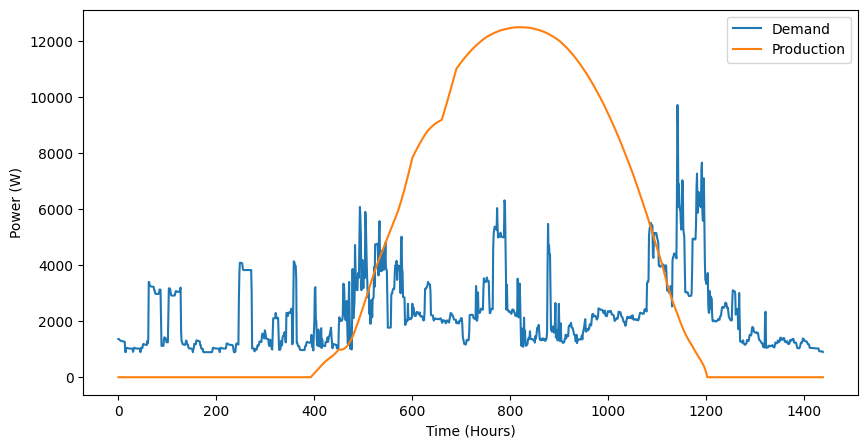

In [75]:
opt[:24*60*1]["Demand"].plot(legend=True, label='Demand')
opt[:24*60*1]["Production"].plot(legend=True, label='Production')
plt.rcParams['figure.figsize'] = [10, 5]
plt.xlabel("Time (Hours)")
plt.ylabel("Power (W)")
#plt.savefig('after_opt_2.png')
plt.show()

In [22]:
dfs = cm.dataframes

KeyError: 'demand_df'

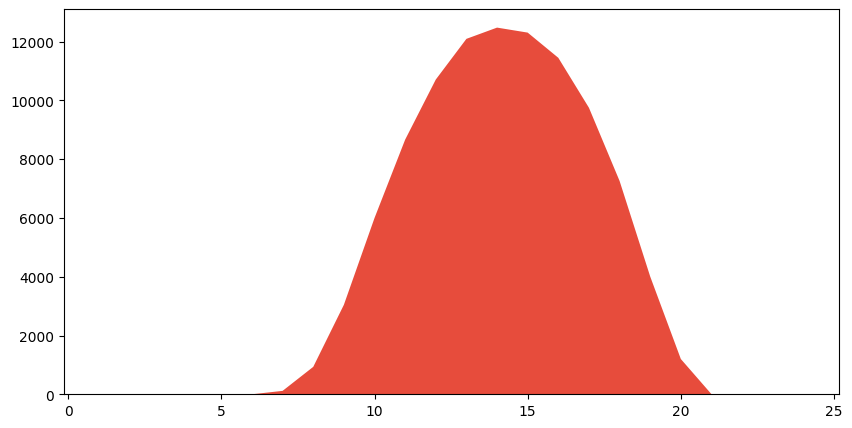

In [23]:
demandd = opt[:24*60*1]
demandd = demandd.set_index("Date")
demandd = demandd.groupby(demandd.index.hour).mean()


# ----- 1 -----


#fig, ax = plt.subplots()
#plt.stackplot(demandd.index, demandd["Production"], dfs['evSoc_df'].sum(), labels=['Production', 'SOC'])
#demandd["Demand"].plot(color='green')
#ax.legend(loc='upper left')
#ax.set_title('After Optimization')
#ax.set_xlabel('Hours')
#ax.set_ylabel('Energy (Wh)')
#plt.savefig('after_opt_2b.png')


# ----- 2 -----

#dfs["prod_used_df"] = dfs["production_df"] - dfs["demand_df"].transpose()[0][1:]
#dfs["prod_used_df"].loc[dfs["prod_used_df"] >= 0] = dfs["production_df"] - dfs["pExp_df"] - dfs["evCharge_df"].sum() + dfs["evDischarge_df"].sum()
#dfs["prod_used_df"].loc[dfs["prod_used_df"] < 0] = dfs["production_df"]

#dfs["battery_used_df"] = dfs["demand_df"].transpose()[0][1:] - dfs["prod_used_df"] - dfs["pImp_df"]

#fig, ax = plt.subplots()
#plt.stackplot(dfs["pImp_df"].index, dfs["pImp_df"],  dfs["prod_used_df"], dfs["battery_used_df"], labels=['Grid', 'Production', 'EVs Discharge'])
#dfs["demand_df"].transpose()[0][1:].plot(color='blue', label='Demand')
#ax.legend(loc='upper left')
#ax.set_title('After Optimization')
#ax.set_xlabel('Hours')
#ax.set_ylabel('Energy (Wh)')
#plt.savefig('after_opt_2b.png')


#----- 3 -----

color_map = ["#9b59b6", "#e74c3c", "#34495e", "#2ecc71"]


fig, ax = plt.subplots()
plt.stackplot(dfs["pImp_df"].index, dfs["pImp_df"],  dfs["production_df"], dfs["evDischarge_df"].sum(), labels=['Grid Import', 'Production', 'EVs Discharge'], colors = color_map)
dfs["demand_df"].transpose()[0][1:].plot(color='green', label='Demand', linewidth=3)
ax.legend(loc='upper left')
ax.set_title('After 2nd Optimization')
ax.set_xlabel('Hours')
ax.set_ylabel('Energy (Wh)')
ax.set_ylim(0, 17000)
#plt.savefig('after_opt_2.png')



fig, ax = plt.subplots()
plt.stackplot(dfs["pExp_df"].index, dfs["pExp_df"], dfs["demand_df"].transpose()[0][1:], dfs["evCharge_df"].sum(), labels=['Grid Export', 'Demand', 'EVs Charge'], colors = color_map)
dfs["production_df"].plot(color='green', label='Production', linewidth=3)

#dfs["evSoc_df"].sum().plot(color='black')
ax.legend(loc='upper left')
ax.set_title('After 2nd Optimization')
ax.set_xlabel('Hours')
ax.set_ylabel('Energy (Wh)')
ax.set_ylim(0, 17000)
#plt.savefig('after_opt_2b.png')

In [ ]:
before = pd.read_csv(path_steps_minutes + '/netload.csv', sep=';')
before.columns = ['Date', 'Demand', 'PV_Production', 'Wind_Production', 'Production', 'Netload']
before['Date'] = pd.to_datetime(before['Date'])
before.set_index('Date')

before[:24*60*1]["Demand"].plot(legend=True, label='Demand')
before[:24*60*1]["Production"].plot(legend=True, label='Production')
plt.rcParams['figure.figsize'] = [10, 5]
plt.xlabel("Time (Hours)")
plt.ylabel("Power (W)")
#plt.savefig('before_opt_2.png')
plt.show()


In [ ]:
beforee = before[:24*60*1]
beforee = beforee.set_index("Date")
beforee = beforee.groupby(beforee.index.hour).mean()


#fig, ax = plt.subplots()
#ax.stackplot(beforee.index, beforee["Production"], labels=['Production'])
#beforee["Demand"].plot(color='green')
#ax.legend(loc='upper left')
#ax.set_title('Before Optimization')
#ax.set_xlabel('Hours')
#ax.set_ylabel('Energy (Wh)')
#plt.savefig('before_opt_2b.png')

beforee["pImp"] = beforee["Demand"] - beforee["Production"]
beforee["pImp"].loc[beforee["pImp"] < 0] = 0


beforee["pExp"] = beforee["Production"] - beforee["Demand"]
beforee["pExp"].loc[beforee["pExp"] < 0] = 0


color_map = ["#e74c3c", "#9b59b6", "#34495e", "#2ecc71"]


fig, ax = plt.subplots()
plt.stackplot(beforee["Production"].index, beforee["Production"], beforee["pImp"], labels=['Production', 'Grid Import'], colors = color_map)
beforee["Demand"].plot(color='green', label='Demand', linewidth=3)
ax.legend(loc='upper left')
ax.set_title('Before Optimization')
ax.set_xlabel('Hours')
ax.set_ylabel('Energy (Wh)')
ax.set_ylim(0, 17000)
#plt.savefig('before_opt_2.png')



fig, ax = plt.subplots()
plt.stackplot(beforee["Demand"].index, beforee["Demand"], beforee["pExp"], labels=['Demand', 'Grid Export'], colors = color_map)
beforee["Production"].plot(color='green', label='Production', linewidth=3)

#dfs["evSoc_df"].sum().plot(color='black')
ax.legend(loc='upper left')
ax.set_title('Before Optimization')
ax.set_xlabel('Hours')
ax.set_ylabel('Energy (Wh)')
ax.set_ylim(0, 17000)
#plt.savefig('before_opt_2b.png')

In [ ]:
# Calculate the difference between Demand and Production
opt['Difference'] = opt['Demand'] - opt['Production']

# Plot the difference
opt[:24*60*1]["Difference"].plot(legend=True, label='Difference')

In [ ]:
def get_energy_used_from_grid(df):
  return df['pImp_df'].sum()/1000

def get_energy_used_from_production(df):
  return sum((df['production_df'][i] - df['pExp_df'][i])/1000 for i in np.arange(1,25) if df['production_df'][i] >= df['pExp_df'][i]) + sum((df['production_df'][i]/1000 for i in np.arange(1,25) if df['production_df'][i] < df['pExp_df'][i])) + df['evCharge_df'].sum().sum()/1000
  #return (df['production_df'].sum() - df['pExp_df'].sum())/1000

def get_energy_not_used_from_production(df):
  return df['pExp_df'].sum()/1000

def get_self_sufficiency(df):
  return get_energy_used_from_production(df) / (get_energy_used_from_grid(df) + get_energy_used_from_production(df))*100

def get_self_consumption(df):
  return get_energy_used_from_production(df) / (get_energy_used_from_production(df) + get_energy_not_used_from_production(df))*100

def get_costs(df):
  degradation_cost = 0.08
  return (df['importPrices_df']*df['pImp_df']/1000 - df['exportPrices_df']*df['pExp_df']/1000).sum() + (df['evCharge_df'].sum().sum()+df['evDischarge_df'].sum().sum())/1000*degradation_cost

def get_self_sufficiency2(df):

  demand = df['demand_df'].sum().sum()/1000
  production = df['production_df'].sum()/1000
  export = get_energy_not_used_from_production(df)
  charge = df['evCharge_df'].sum().sum()/1000
  discharge = df['evDischarge_df'].sum().sum()/1000
  efficiency = 0.97
  loss = (1-efficiency) * (charge+discharge)
  ess_initial = dfs['evSoc_df'].transpose().iloc[0].sum()/1000
  ess_final = dfs['evSoc_df'].transpose().iloc[-1].sum()/1000
  delta_ess = ess_final - ess_initial
  grid = get_energy_used_from_grid(df)

  used_prod = demand-grid
  not_used_prod = production - used_prod
  not_used_prod2 = export + loss
  k = production / (grid + production)


  print("k: ", k)
  print("demand: ", demand)
  print("production: ", production)
  print("export: ", export)
  print("charge: ", charge)
  print("discharge: ", discharge)
  print("loss: ", loss)
  print("ess_initial: ", ess_initial)
  print("ess_final: ", ess_final)
  print("delta_ess: ", delta_ess)
  print("used prod: ", used_prod)
  print("not used prod: ", not_used_prod)
  print(100 * (production - k * (export + loss + delta_ess)) / demand)
  print((production - export - loss)/demand)
  print((production - (export - get_energy_used_from_grid(df)) + loss + delta_ess)/demand)

  return 100 * (production - k * (export + loss + delta_ess)) / demand

In [ ]:
before_df = before.iloc[:24*60]
dt = pd.to_datetime(before_df.Date)
before_demand_df = before_df.groupby([dt.dt.hour]).Demand.mean()
before_demand_df.index = np.arange(1, len(before_demand_df) + 1)

cost_df = dfs['importPrices_df']*before_demand_df/1000
print(cost_df)

In [ ]:
# Calculate the metrics for the input
evaluation_in = Evaluation(before.iloc[:24*60], 0)

print("Energy Used from Grid: " + "{:.2f}".format(evaluation_in.get_energy_used_from_grid()) + " kWh")
print("Energy Used from Production: " + "{:.2f}".format(evaluation_in.get_energy_used_from_pv()*2) + " kWh")
print("Energy Not Used from Production: " + "{:.2f}".format(evaluation_in.get_energy_not_used_from_pv()) + " kWh")
print("Self Sufficiency (SS): " + "{:.2f}".format(evaluation_in.get_self_sufficiency()*100) + "%")
print("Self Consumption (SC): " + "{:.2f}".format(evaluation_in.get_self_consumption()*100) + "%")
print("Total Cost: " + "{:.2f}".format(cost_df.sum()) + "€")

In [ ]:
#print(dfs['evCharge_df'])
#print(dfs['evCharge_df'].sum(axis=0))
#print(dfs['demand_df'].transpose())
#print(dfs['evSoc_df'].sum(axis=0))
#print(dfs['evDischarge_df'])
# Plot ev charge graph
dfs['evCharge_df'].sum(axis=0).plot(legend=True, label='EV Charge')
dfs['evDischarge_df'].sum(axis=0).plot(legend=True, label='EV Discharge')
dfs['evSoc_df'].sum(axis=0).plot(legend=True, label='EV SOC')
#dfs['demand_df'].transpose().plot(legend=True, label='Demand')
plt.show()


In [ ]:
# Calculate the metrics for the output
evaluation_out = Evaluation(opt.iloc[:24*60], 0)

print("Energy Used from Grid: " + "{:.2f}".format(get_energy_used_from_grid(dfs)) + " kWh")
print("Energy Used from Production: " + "{:.2f}".format(get_energy_used_from_production(dfs)) + " kWh")
print("Energy Not Used from Production: " + "{:.2f}".format(get_energy_not_used_from_production(dfs)) + " kWh")
print("Self Sufficiency (SS): " + "{:.2f}".format(get_self_sufficiency(dfs)) + "%")
print("Self Sufficiency 2 (SS): " + "{:.2f}".format(get_self_sufficiency2(dfs)) + "%")
print("Self Consumption (SC): " + "{:.2f}".format(get_self_consumption(dfs)) + "%")
print("Total Cost: " + "{:.2f}".format(get_costs(dfs)) + "€")

In [ ]:
def show_timeslots_placement_graph_double(path, day):
  abc = pd.read_csv(path + '/netload.csv', sep=';')
  abc.columns = ['Date', 'Demand', 'PV_Production', 'Wind_Production', 'Production', 'Netload']
  abc.drop('Netload', inplace=True, axis=1)
  abc.drop('Demand', inplace=True, axis=1)
  # abc.drop('Production', inplace=True, axis=1)

  abc.set_index('Date')

  tim2 = pd.read_csv(path + '/house0/WASHINGMACHINE.csv', sep=';')
  # tim2['Power'] = tim2['Power'] + 62.1 * 30;
  tim2 = tim2.rename(columns={"Power": "Timeslot 2 - Washing Machine - House 1"})
  tim2.set_index('Date')

  tim25 = pd.read_csv(path + '/house3/DISHWASHER.csv', sep=';')
  # tim10['Power'] = tim10['Power'] + 62.1 * 30
  tim25 = tim25.rename(columns={"Power": "Timeslot 25 - Dishwasher - House 4"})
  tim25.set_index('Date')

  tim33 = pd.read_csv(path + '/house4/WASHINGMACHINE.csv', sep=';')
  # tim33['Power'] = tim33['Power'] + 62.1 * 30
  tim33 = tim33.rename(columns={"Power": "Timeslot 33 - Washing Machine - House 5"})
  tim33.set_index('Date')

  df = pd.merge(pd.merge(pd.merge(abc, tim2, on='Date', how='left'), tim25, on='Date', how='left'), tim33, on='Date',
                how='left')
  df.set_index('Date')

  df['Time'] = df['Date'].map(lambda x: datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").strftime("%H:%M"))

  fig, ax1 = plt.subplots()

  ax1.set_xlabel('Time')
  ax1.set_ylabel('Power (W)', color='red')
  plt1 = ax1.plot(df['Time'][24*60*(day-1):24*60*day], df["Timeslot 2 - Washing Machine - House 1"][24*60*(day-1):24*60*day], color='red',
                  label='Timeslot 2 - Washing Machine - House 1')
  plt2 = ax1.plot(df['Time'][24*60*(day-1):24*60*day], df["Timeslot 25 - Dishwasher - House 4"][24*60*(day-1):24*60*day], color='green',
                  label='Timeslot 25 - Dishwasher - House 4')
  plt3 = ax1.plot(df['Time'][24*60*(day-1):24*60*day], df["Timeslot 33 - Washing Machine - House 5"][24*60*(day-1):24*60*day], color='orange',
                  label='Timeslot 33 - Washing Machine - House 5')
  ax1.axis(ymin=-280, ymax=6000)
  # ax1.set_xticks(df['Time'])
  # ax1.tick_params(axis='y', labelcolor='red')

  # Adding Twin Axes

  ax2 = ax1.twinx()

  ax2.set_ylabel('Production (W)', color='blue')
  plt4 = ax2.plot(df['Time'][24*60*(day-1):24*60*day], df["Production"][24*60*(day-1):24*60*day], color='blue', label='Production')

  # adds space between x values because there are a lot of different values for the x-axis and not all of them can be displayed
  # ref. https://stackoverflow.com/questions/48251417/matplotlib-plots-multiple-dark-lines-on-x-axis
  spacing = 200
  visible = ax1.xaxis.get_ticklabels()[::spacing]
  for label in ax1.xaxis.get_ticklabels():
    if label not in visible:
      label.set_visible(False)
  visible = ax1.xaxis.get_ticklines()[::spacing]
  for label in ax1.xaxis.get_ticklines():
    if label not in visible:
      label.set_visible(False)

  # ax.get_xaxis().set_visible(False)
  # Show plot

  # join labels of both axis (ax1 and ax2)
  plts = plt1 + plt2 + plt3 + plt4
  labs = [l.get_label() for l in plts]
  ax1.legend(plts, labs, loc=0)

  #plt.savefig(str(day) + '.png')
  plt.show()

In [ ]:
for day in range(1, 2):
  print("Day " + str(day) + ":")
  #show_timeslots_placement_graph_double(path_steps_minutes, day)
  show_timeslots_placement_graph_double(path_steps_after_first, day)

In [ ]:
dfs['pImp_df'].sum().sum()